# Automatic program Repair (APR)


In [2]:


import sys
import os
sys.path.append(os.path.abspath(os.path.join('..')))
from utils.simple_metrics import compute_and_store_metrics
from utils.visualization import compare_groundtruth_vs_corrected_histograms, compare_metrics_versus_bug_histograms, plot_column_distribution, plot_metrics_boxplots
from bug_detective.detective import process_prompt_dataset
from data_loader.loader import load_buggy_dataset, load_data, save_data
import numpy as np
import pandas as pd



# Add the data_loader module to the path

# Import data loader functions

# Load sample train data
# print("Loading sample train data...")

# Load buggy train dataset
buggy_train_df = load_buggy_dataset('train')

In [ ]:
sample_metrics_default = load_data('100_metrics.pkl')
sample_metrics_prompt = load_data('100_metrics_prompt_1.pkl')

In [5]:
from Bugdetectiveai.scr.utils.visualization import create_metrics_summary_table

response_columns = [column for column in sample_metrics_default.columns if "response" in column]
summary_table_default = create_metrics_summary_table(sample_metrics_default,response_columns)
response_columns_prompt = [column for column in sample_metrics_prompt.columns if "response" in column]
summary_table_prompt = create_metrics_summary_table(sample_metrics_prompt,response_columns_prompt)

Creating metrics summary table for 6 response columns...

=== Metrics Summary Table ===
Models: 6
Metrics: 9
Statistics shown: mean ± std
Sample counts shown in parentheses

                                       exact_match              ast_score             text_score   ast_score_normalized               codebleu      ngram_match_score weighted_ngram_match_score     syntax_match_score   dataflow_match_score
Qwen-2.5-Coder-32B-Instruct  0.010 ± 0.100 (n=100)  0.215 ± 0.364 (n=100)  0.743 ± 0.206 (n=100)  0.259 ± 0.400 (n=100)  0.756 ± 0.181 (n=100)  0.682 ± 0.257 (n=100)      0.749 ± 0.225 (n=100)  0.796 ± 0.188 (n=100)  0.743 ± 0.247 (n=100)
Gpt-4O-Mini                  0.000 ± 0.000 (n=100)  0.221 ± 0.363 (n=100)  0.678 ± 0.268 (n=100)  0.254 ± 0.388 (n=100)  0.703 ± 0.225 (n=100)  0.605 ± 0.293 (n=100)      0.685 ± 0.288 (n=100)  0.741 ± 0.229 (n=100)  0.685 ± 0.286 (n=100)
Gemini-2.0-Flash-001         0.010 ± 0.100 (n=100)  0.180 ± 0.319 (n=100)  0.752 ± 0.222 (n=100)  0.216 ± 0.3

In [7]:

# Create summary table for prompt metrics
# response_columns_prompt = [col for col in sample_prompt_metrics.columns if "response" in col]
# summary_table_prompt = create_metrics_summary_table(sample_prompt_metrics, response_columns_prompt)

# Add (prompt_1) to row names
summary_table_prompt.index = [f"{idx} (prompt_1)" for idx in summary_table_prompt.index]
summary_table_default.index = [f"{idx}" for idx in summary_table_default.index]  # Ensure no suffix for original

# Concatenate and sort rows alphabetically
summary_table_combined = pd.concat([summary_table_default, summary_table_prompt])
summary_table_combined = summary_table_combined.sort_index()

# Replace summary_table with the combined, sorted table for further use
summary_table_combined.head(10)

,exact_match,ast_score,text_score,ast_score_normalized,codebleu,ngram_match_score,weighted_ngram_match_score,syntax_match_score,dataflow_match_score
Codestral-2501,0.000 ± 0.000 (n=100),0.246 ± 0.389 (n=100),0.763 ± 0.192 (n=100),0.269 ± 0.400 (n=100),0.771 ± 0.187 (n=100),0.719 ± 0.245 (n=100),0.764 ± 0.221 (n=100),0.804 ± 0.190 (n=100),0.752 ± 0.247 (n=100)
Codestral-2501 (prompt_1) (prompt_1),0.000 ± 0.000 (n=100),0.239 ± 0.380 (n=100),0.756 ± 0.195 (n=100),0.265 ± 0.395 (n=100),0.776 ± 0.184 (n=100),0.718 ± 0.251 (n=100),0.771 ± 0.213 (n=100),0.814 ± 0.176 (n=100),0.755 ± 0.251 (n=100)
Gemini-2.0-Flash-001,0.010 ± 0.100 (n=100),0.180 ± 0.319 (n=100),0.752 ± 0.222 (n=100),0.216 ± 0.359 (n=100),0.716 ± 0.172 (n=100),0.629 ± 0.260 (n=100),0.718 ± 0.221 (n=100),0.766 ± 0.172 (n=100),0.694 ± 0.241 (n=100)
Gemini-2.5-Flash,0.000 ± 0.000 (n=100),0.189 ± 0.334 (n=100),0.677 ± 0.253 (n=100),0.273 ± 0.399 (n=100),0.678 ± 0.187 (n=100),0.511 ± 0.273 (n=100),0.704 ± 0.227 (n=100),0.757 ± 0.191 (n=100),0.645 ± 0.260 (n=100)
Gemini-2.5-Flash (prompt_1) (prompt_1),0.000 ± 0.000 (n=100),0.213 ± 0.358 (n=100),0.780 ± 0.227 (n=100),0.261 ± 0.395 (n=100),0.728 ± 0.198 (n=100),0.634 ± 0.288 (n=100),0.726 ± 0.238 (n=100),0.775 ± 0.193 (n=100),0.713 ± 0.254 (n=100)
Gpt-4.1,0.000 ± 0.000 (n=100),0.199 ± 0.338 (n=100),0.666 ± 0.218 (n=100),0.275 ± 0.396 (n=100),0.661 ± 0.196 (n=100),0.571 ± 0.254 (n=100),0.663 ± 0.246 (n=100),0.735 ± 0.184 (n=100),0.634 ± 0.265 (n=100)
Gpt-4O-Mini,0.000 ± 0.000 (n=100),0.221 ± 0.363 (n=100),0.678 ± 0.268 (n=100),0.254 ± 0.388 (n=100),0.703 ± 0.225 (n=100),0.605 ± 0.293 (n=100),0.685 ± 0.288 (n=100),0.741 ± 0.229 (n=100),0.685 ± 0.286 (n=100)
Gpt-4O-Mini (prompt_1) (prompt_1),0.000 ± 0.000 (n=100),0.232 ± 0.364 (n=100),0.757 ± 0.217 (n=100),0.272 ± 0.396 (n=100),0.744 ± 0.181 (n=100),0.659 ± 0.248 (n=100),0.740 ± 0.225 (n=100),0.784 ± 0.186 (n=100),0.729 ± 0.243 (n=100)
Qwen-2.5-Coder-32B-Instruct,0.010 ± 0.100 (n=100),0.215 ± 0.364 (n=100),0.743 ± 0.206 (n=100),0.259 ± 0.400 (n=100),0.756 ± 0.181 (n=100),0.682 ± 0.257 (n=100),0.749 ± 0.225 (n=100),0.796 ± 0.188 (n=100),0.743 ± 0.247 (n=100)
Qwen-2.5-Coder-32B-Instruct (prompt_1) (prompt_1),0.020 ± 0.141 (n=100),0.229 ± 0.377 (n=100),0.812 ± 0.196 (n=100),0.316 ± 0.430 (n=100),0.757 ± 0.181 (n=100),0.692 ± 0.253 (n=100),0.746 ± 0.222 (n=100),0.783 ± 0.182 (n=100),0.749 ± 0.246 (n=100)


In [ ]:
summary_table_combined.drop(columns=["exact_match"], errors="ignore").head(10)

,ast_score,text_score,ast_score_normalized,codebleu,ngram_match_score,weighted_ngram_match_score,syntax_match_score,dataflow_match_score
Codestral-2501,0.246 ± 0.389 (n=100),0.763 ± 0.192 (n=100),0.269 ± 0.400 (n=100),0.771 ± 0.187 (n=100),0.719 ± 0.245 (n=100),0.764 ± 0.221 (n=100),0.804 ± 0.190 (n=100),0.752 ± 0.247 (n=100)
Codestral-2501 (prompt_1),0.239 ± 0.380 (n=100),0.756 ± 0.195 (n=100),0.265 ± 0.395 (n=100),0.776 ± 0.184 (n=100),0.718 ± 0.251 (n=100),0.771 ± 0.213 (n=100),0.814 ± 0.176 (n=100),0.755 ± 0.251 (n=100)
Gemini-2.0-Flash-001,0.180 ± 0.319 (n=100),0.752 ± 0.222 (n=100),0.216 ± 0.359 (n=100),0.716 ± 0.172 (n=100),0.629 ± 0.260 (n=100),0.718 ± 0.221 (n=100),0.766 ± 0.172 (n=100),0.694 ± 0.241 (n=100)
Gemini-2.5-Flash,0.189 ± 0.334 (n=100),0.677 ± 0.253 (n=100),0.273 ± 0.399 (n=100),0.678 ± 0.187 (n=100),0.511 ± 0.273 (n=100),0.704 ± 0.227 (n=100),0.757 ± 0.191 (n=100),0.645 ± 0.260 (n=100)
Gemini-2.5-Flash (prompt_1),0.213 ± 0.358 (n=100),0.780 ± 0.227 (n=100),0.261 ± 0.395 (n=100),0.728 ± 0.198 (n=100),0.634 ± 0.288 (n=100),0.726 ± 0.238 (n=100),0.775 ± 0.193 (n=100),0.713 ± 0.254 (n=100)
Gpt-4.1,0.199 ± 0.338 (n=100),0.666 ± 0.218 (n=100),0.275 ± 0.396 (n=100),0.661 ± 0.196 (n=100),0.571 ± 0.254 (n=100),0.663 ± 0.246 (n=100),0.735 ± 0.184 (n=100),0.634 ± 0.265 (n=100)
Gpt-4O-Mini,0.221 ± 0.363 (n=100),0.678 ± 0.268 (n=100),0.254 ± 0.388 (n=100),0.703 ± 0.225 (n=100),0.605 ± 0.293 (n=100),0.685 ± 0.288 (n=100),0.741 ± 0.229 (n=100),0.685 ± 0.286 (n=100)
Gpt-4O-Mini (prompt_1),0.232 ± 0.364 (n=100),0.757 ± 0.217 (n=100),0.272 ± 0.396 (n=100),0.744 ± 0.181 (n=100),0.659 ± 0.248 (n=100),0.740 ± 0.225 (n=100),0.784 ± 0.186 (n=100),0.729 ± 0.243 (n=100)
Qwen-2.5-Coder-32B-Instruct,0.215 ± 0.364 (n=100),0.743 ± 0.206 (n=100),0.259 ± 0.400 (n=100),0.756 ± 0.181 (n=100),0.682 ± 0.257 (n=100),0.749 ± 0.225 (n=100),0.796 ± 0.188 (n=100),0.743 ± 0.247 (n=100)
Qwen-2.5-Coder-32B-Instruct (prompt_1),0.229 ± 0.377 (n=100),0.812 ± 0.196 (n=100),0.316 ± 0.430 (n=100),0.757 ± 0.181 (n=100),0.692 ± 0.253 (n=100),0.746 ± 0.222 (n=100),0.783 ± 0.182 (n=100),0.749 ± 0.246 (n=100)


### sample 200


In [10]:
sample_metrics_default_200 = load_data('200_metrics_prompt_default(trunc).pkl')
sample_metrics_prompt_200 = load_data('200_metrics_prompt_1.pkl')

In [11]:
response_columns = [column for column in sample_metrics_default_200.columns if "response" in column]
summary_table_default_200 = create_metrics_summary_table(sample_metrics_default_200,response_columns)
response_columns_prompt = [column for column in sample_metrics_prompt_200.columns if "response" in column]
summary_table_prompt_200 = create_metrics_summary_table(sample_metrics_prompt_200,response_columns_prompt)

Creating metrics summary table for 4 response columns...

=== Metrics Summary Table ===
Models: 4
Metrics: 9
Statistics shown: mean ± std
Sample counts shown in parentheses

                                       exact_match              ast_score             text_score   ast_score_normalized               codebleu      ngram_match_score weighted_ngram_match_score     syntax_match_score   dataflow_match_score
Qwen-2.5-Coder-32B-Instruct  0.000 ± 0.000 (n=200)  0.192 ± 0.365 (n=200)  0.746 ± 0.209 (n=200)  0.214 ± 0.376 (n=200)  0.772 ± 0.191 (n=200)  0.726 ± 0.250 (n=200)      0.776 ± 0.222 (n=200)  0.801 ± 0.184 (n=200)  0.738 ± 0.269 (n=200)
Gpt-4O                       0.005 ± 0.071 (n=200)  0.189 ± 0.361 (n=200)  0.710 ± 0.236 (n=200)  0.192 ± 0.358 (n=200)  0.750 ± 0.207 (n=200)  0.688 ± 0.266 (n=200)      0.759 ± 0.247 (n=200)  0.794 ± 0.197 (n=200)  0.699 ± 0.284 (n=200)
Codestral-2501               0.000 ± 0.000 (n=200)  0.191 ± 0.366 (n=200)  0.747 ± 0.209 (n=200)  0.206 ± 0.3

In [12]:
# Add (prompt_1) to row names
summary_table_prompt_200.index = [f"{idx} (prompt_1)" for idx in summary_table_prompt_200.index]
summary_table_default_200.index = [f"{idx}" for idx in summary_table_default_200.index]  # Ensure no suffix for original

# Concatenate and sort rows alphabetically
summary_table_combined = pd.concat([summary_table_default_200, summary_table_prompt_200])
summary_table_combined = summary_table_combined.sort_index()

# Replace summary_table with the combined, sorted table for further use
summary_table_combined.head(10)

,exact_match,ast_score,text_score,ast_score_normalized,codebleu,ngram_match_score,weighted_ngram_match_score,syntax_match_score,dataflow_match_score
Claude-3.5-Sonnet,0.000 ± 0.000 (n=200),0.111 ± 0.277 (n=200),0.687 ± 0.217 (n=200),0.200 ± 0.368 (n=200),0.724 ± 0.201 (n=200),0.653 ± 0.258 (n=200),0.725 ± 0.239 (n=200),0.771 ± 0.174 (n=200),0.692 ± 0.276 (n=200)
Claude-3.5-Sonnet (prompt_1),0.000 ± 0.000 (n=200),0.126 ± 0.290 (n=200),0.712 ± 0.206 (n=200),0.214 ± 0.374 (n=200),0.750 ± 0.177 (n=200),0.686 ± 0.240 (n=200),0.754 ± 0.215 (n=200),0.791 ± 0.158 (n=200),0.711 ± 0.264 (n=200)
Codestral-2501,0.000 ± 0.000 (n=200),0.191 ± 0.366 (n=200),0.747 ± 0.209 (n=200),0.206 ± 0.375 (n=200),0.778 ± 0.197 (n=200),0.745 ± 0.249 (n=200),0.784 ± 0.223 (n=200),0.819 ± 0.168 (n=200),0.735 ± 0.274 (n=200)
Codestral-2501 (prompt_1),0.000 ± 0.000 (n=200),0.204 ± 0.377 (n=200),0.758 ± 0.207 (n=200),0.200 ± 0.369 (n=200),0.798 ± 0.185 (n=200),0.766 ± 0.239 (n=200),0.803 ± 0.214 (n=200),0.828 ± 0.166 (n=200),0.758 ± 0.262 (n=200)
Gpt-4O,0.005 ± 0.071 (n=200),0.189 ± 0.361 (n=200),0.710 ± 0.236 (n=200),0.192 ± 0.358 (n=200),0.750 ± 0.207 (n=200),0.688 ± 0.266 (n=200),0.759 ± 0.247 (n=200),0.794 ± 0.197 (n=200),0.699 ± 0.284 (n=200)
Gpt-4O (prompt_1),0.010 ± 0.100 (n=200),0.202 ± 0.373 (n=200),0.734 ± 0.222 (n=200),0.196 ± 0.362 (n=200),0.771 ± 0.198 (n=200),0.714 ± 0.257 (n=200),0.778 ± 0.237 (n=200),0.804 ± 0.193 (n=200),0.729 ± 0.273 (n=200)
Qwen-2.5-Coder-32B-Instruct,0.000 ± 0.000 (n=200),0.192 ± 0.365 (n=200),0.746 ± 0.209 (n=200),0.214 ± 0.376 (n=200),0.772 ± 0.191 (n=200),0.726 ± 0.250 (n=200),0.776 ± 0.222 (n=200),0.801 ± 0.184 (n=200),0.738 ± 0.269 (n=200)
Qwen-2.5-Coder-32B-Instruct (prompt_1),0.010 ± 0.100 (n=200),0.211 ± 0.385 (n=200),0.816 ± 0.210 (n=200),0.257 ± 0.408 (n=200),0.790 ± 0.182 (n=200),0.748 ± 0.241 (n=200),0.793 ± 0.216 (n=200),0.819 ± 0.170 (n=200),0.756 ± 0.262 (n=200)


In [15]:
instruction_prompt = "You are a helpful assistant that corrects the code based on the traceback error. You must respect the original code structure and the original code style"

4 - fechada pequena, aberta pequena focada em code


In [16]:
from llm_models.open_router import create_openrouter_model

qwen_model = create_openrouter_model(
    model_name="qwen/qwen-2.5-coder-32b-instruct",
    temperature=0.0,
    max_tokens=1000
)
gpt_4o_mini_model = create_openrouter_model(
    model_name="openai/gpt-4o-mini",
    temperature=0.0,
    max_tokens=1000
)

gemini_2_5_flash_model = create_openrouter_model(
    model_name="google/gemini-2.5-flash",
    temperature=0.0,
    max_tokens=1000
)

codestral_model = create_openrouter_model(
    model_name="mistralai/codestral-2501",
    temperature=0.0,
    max_tokens=1000
)
gpt_4_1_model = create_openrouter_model(
    model_name="openai/gpt-4.1",
    temperature=0.0,
    max_tokens=1000
)

In [8]:
print(type(prompt_data))
if not isinstance(prompt_data, pd.DataFrame):
    prompt_data = pd.DataFrame(prompt_data)
print(type(prompt_data))

<class 'pandas.core.frame.DataFrame'>
<class 'pandas.core.frame.DataFrame'>


In [17]:
import pandas as pd

# Ensure prompt_data is a DataFrame
# if not isinstance(prompt_data, pd.DataFrame):
# prompt_data = pd.DataFrame(prompt_data)

outputs_qwen = await process_prompt_dataset(open_router_model=qwen_model, prompt_dataset=prompt_data, instruction_prompt=instruction_prompt)
prompt_data['response_qwen-2.5-coder-32b-instruct'] = outputs_qwen

outputs_gpt_4o_mini = await process_prompt_dataset(open_router_model=gpt_4o_mini_model, prompt_dataset=prompt_data, instruction_prompt=instruction_prompt)
prompt_data['response_gpt-4o-mini'] = outputs_gpt_4o_mini

outputs_gemini_2_5_flash = await process_prompt_dataset(open_router_model=gemini_2_5_flash_model, prompt_dataset=prompt_data, instruction_prompt=instruction_prompt)
prompt_data['response_gemini-2.5-flash'] = outputs_gemini_2_5_flash

outputs_codestral = await process_prompt_dataset(open_router_model=codestral_model, prompt_dataset=prompt_data, instruction_prompt=instruction_prompt)
prompt_data['response_codestral-2501'] = outputs_codestral

# outputs_gpt_4_1 = await process_prompt_dataset(gpt_4_1_model, prompt_data,instruction_prompt=instruction_prompt)
# prompt_data['response_gpt-4.1'] = outputs_gpt_4_1

Processing sample 200/200: 100%|█████████████████████████████| 200/200 [12:44<00:00,  3.82s/samples]


In [21]:
prompt_data = compute_and_store_metrics(prompt_data)
# Create summary table for prompt metrics
response_columns_prompt = [col for col in prompt_data.columns if "response" in col]
summary_table_prompt_100 = create_metrics_summary_table(prompt_data, response_columns_prompt)

Computing metrics for after_merge_without_docstrings vs 4 response columns...
Processing response_qwen-2.5-coder-32b-instruct...


Computing response_qwen-2.5-coder-32b-instruct: 100%|██████████| 200/200 [00:10<00:00, 18.95it/s]


  Added 9 metric columns for response_qwen-2.5-coder-32b-instruct
Processing response_gpt-4o-mini...


Computing response_gpt-4o-mini: 100%|██████████| 200/200 [00:12<00:00, 16.16it/s]


  Added 9 metric columns for response_gpt-4o-mini
Processing response_gemini-2.5-flash...


Computing response_gemini-2.5-flash: 100%|██████████| 200/200 [00:09<00:00, 21.03it/s]


  Added 9 metric columns for response_gemini-2.5-flash
Processing response_codestral-2501...


Computing response_codestral-2501: 100%|██████████| 200/200 [00:12<00:00, 16.50it/s]

  Added 9 metric columns for response_codestral-2501
Completed! Added metrics for 4 response columns.
Creating metrics summary table for 4 response columns...

=== Metrics Summary Table ===
Models: 4
Metrics: 9
Statistics shown: mean ± std
Sample counts shown in parentheses

                                       exact_match              ast_score             text_score   ast_score_normalized               codebleu      ngram_match_score weighted_ngram_match_score     syntax_match_score   dataflow_match_score
Qwen-2.5-Coder-32B-Instruct  0.010 ± 0.100 (n=200)  0.191 ± 0.365 (n=200)  0.805 ± 0.210 (n=200)  0.271 ± 0.416 (n=200)  0.774 ± 0.190 (n=200)  0.733 ± 0.245 (n=200)      0.779 ± 0.218 (n=200)  0.805 ± 0.175 (n=200)  0.736 ± 0.268 (n=200)
Gpt-4O-Mini                  0.005 ± 0.071 (n=200)  0.191 ± 0.361 (n=200)  0.747 ± 0.238 (n=200)  0.204 ± 0.370 (n=200)  0.756 ± 0.200 (n=200)  0.677 ± 0.258 (n=200)      0.764 ± 0.242 (n=200)  0.796 ± 0.196 (n=200)  0.712 ± 0.281 (n=200)
Gemini-

In [22]:
summary_table_prompt_100.head()

,exact_match,ast_score,text_score,ast_score_normalized,codebleu,ngram_match_score,weighted_ngram_match_score,syntax_match_score,dataflow_match_score
Qwen-2.5-Coder-32B-Instruct,0.010 ± 0.100 (n=200),0.191 ± 0.365 (n=200),0.805 ± 0.210 (n=200),0.271 ± 0.416 (n=200),0.774 ± 0.190 (n=200),0.733 ± 0.245 (n=200),0.779 ± 0.218 (n=200),0.805 ± 0.175 (n=200),0.736 ± 0.268 (n=200)
Gpt-4O-Mini,0.005 ± 0.071 (n=200),0.191 ± 0.361 (n=200),0.747 ± 0.238 (n=200),0.204 ± 0.370 (n=200),0.756 ± 0.200 (n=200),0.677 ± 0.258 (n=200),0.764 ± 0.242 (n=200),0.796 ± 0.196 (n=200),0.712 ± 0.281 (n=200)
Gemini-2.5-Flash,0.000 ± 0.000 (n=200),0.163 ± 0.333 (n=200),0.786 ± 0.225 (n=200),0.202 ± 0.367 (n=200),0.753 ± 0.196 (n=200),0.687 ± 0.261 (n=200),0.762 ± 0.224 (n=200),0.798 ± 0.165 (n=200),0.713 ± 0.273 (n=200)
Codestral-2501,0.000 ± 0.000 (n=200),0.192 ± 0.367 (n=200),0.745 ± 0.211 (n=200),0.203 ± 0.370 (n=200),0.782 ± 0.196 (n=200),0.744 ± 0.250 (n=200),0.785 ± 0.223 (n=200),0.818 ± 0.169 (n=200),0.745 ± 0.272 (n=200)


### Save data


In [ ]:
# import pickle
# import pandas as pd
# from datetime import datetime
# from pathlib import Path
# import os

# data_path = '/Users/zanchitta/Developer/BugDetectiveAI/Bugdetectiveai/data/checkpoints'

# # Get number of rows
# num_rows = len(sample_data)

# # Get all response columns
# response_columns = [col for col in sample_data.columns if "response_" in col]
# response_names = "_".join([col.replace("response_", "") for col in response_columns])

# # Compose file name
# file_name = f"sample_data_{num_rows}_rows_{response_names}.pkl"
# file_path = os.path.join(data_path, file_name)

# Path(data_path).mkdir(parents=True, exist_ok=True)
# with open(file_path, 'wb') as f:
#     pickle.dump(sample_data, f)
# print(f"Data saved to: {file_path}")

### Load Data


In [19]:
save_data(prompt_data,"200_metrics_prompt_1.pkl")

Data saved to: /Users/zanchitta/Developer/BugDetectiveAI/Bugdetectiveai/data/checkpoints/200_metrics_prompt_1.pkl


'/Users/zanchitta/Developer/BugDetectiveAI/Bugdetectiveai/data/checkpoints/200_metrics_prompt_1.pkl'

Creating boxplots using stored metrics for 4 response columns...


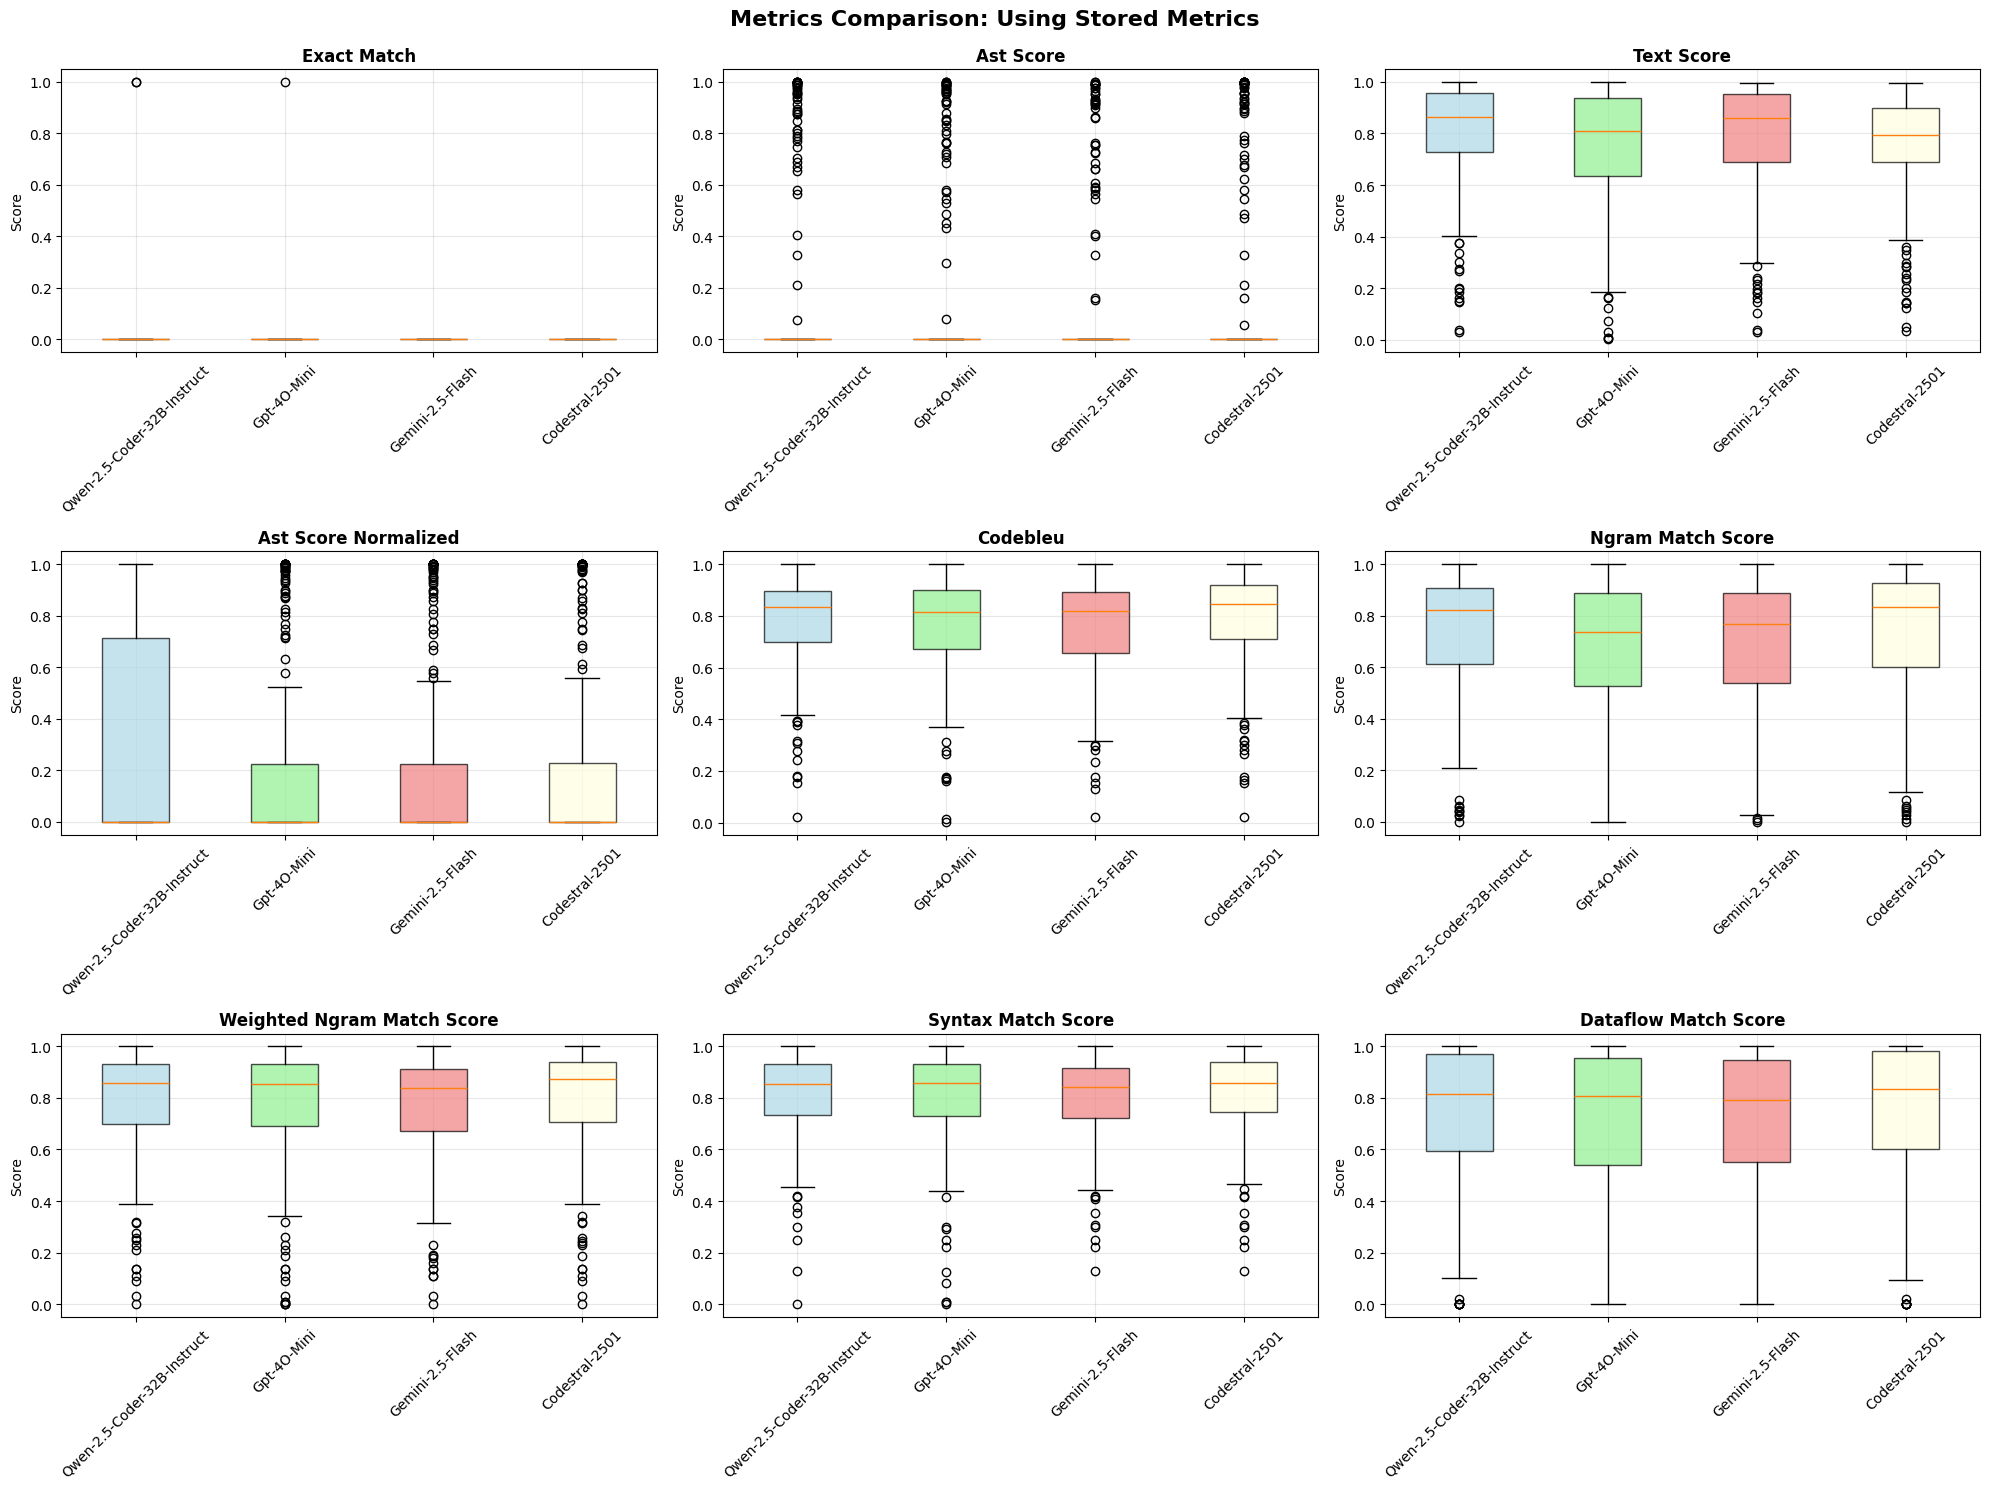


=== SUMMARY STATISTICS (FROM STORED METRICS) ===
Number of response columns: 4
Number of metrics: 9
Available metrics: ['exact_match', 'ast_score', 'text_score', 'ast_score_normalized', 'codebleu', 'ngram_match_score', 'weighted_ngram_match_score', 'syntax_match_score', 'dataflow_match_score']

Exact Match:
  Qwen-2.5-Coder-32B-Instruct: mean=0.010, std=0.100, median=0.000 (n=200)
  Gpt-4O-Mini: mean=0.005, std=0.071, median=0.000 (n=200)
  Gemini-2.5-Flash: mean=0.000, std=0.000, median=0.000 (n=200)
  Codestral-2501: mean=0.000, std=0.000, median=0.000 (n=200)

Ast Score:
  Qwen-2.5-Coder-32B-Instruct: mean=0.191, std=0.365, median=0.000 (n=200)
  Gpt-4O-Mini: mean=0.191, std=0.361, median=0.000 (n=200)
  Gemini-2.5-Flash: mean=0.163, std=0.333, median=0.000 (n=200)
  Codestral-2501: mean=0.192, std=0.367, median=0.000 (n=200)

Text Score:
  Qwen-2.5-Coder-32B-Instruct: mean=0.805, std=0.210, median=0.864 (n=200)
  Gpt-4O-Mini: mean=0.747, std=0.238, median=0.808 (n=200)
  Gemini-2.

In [20]:

plot_metrics_boxplots(
    prompt_data, reference_column="after_merge_without_docstrings")

Creating boxplots using stored metrics for 4 response columns...


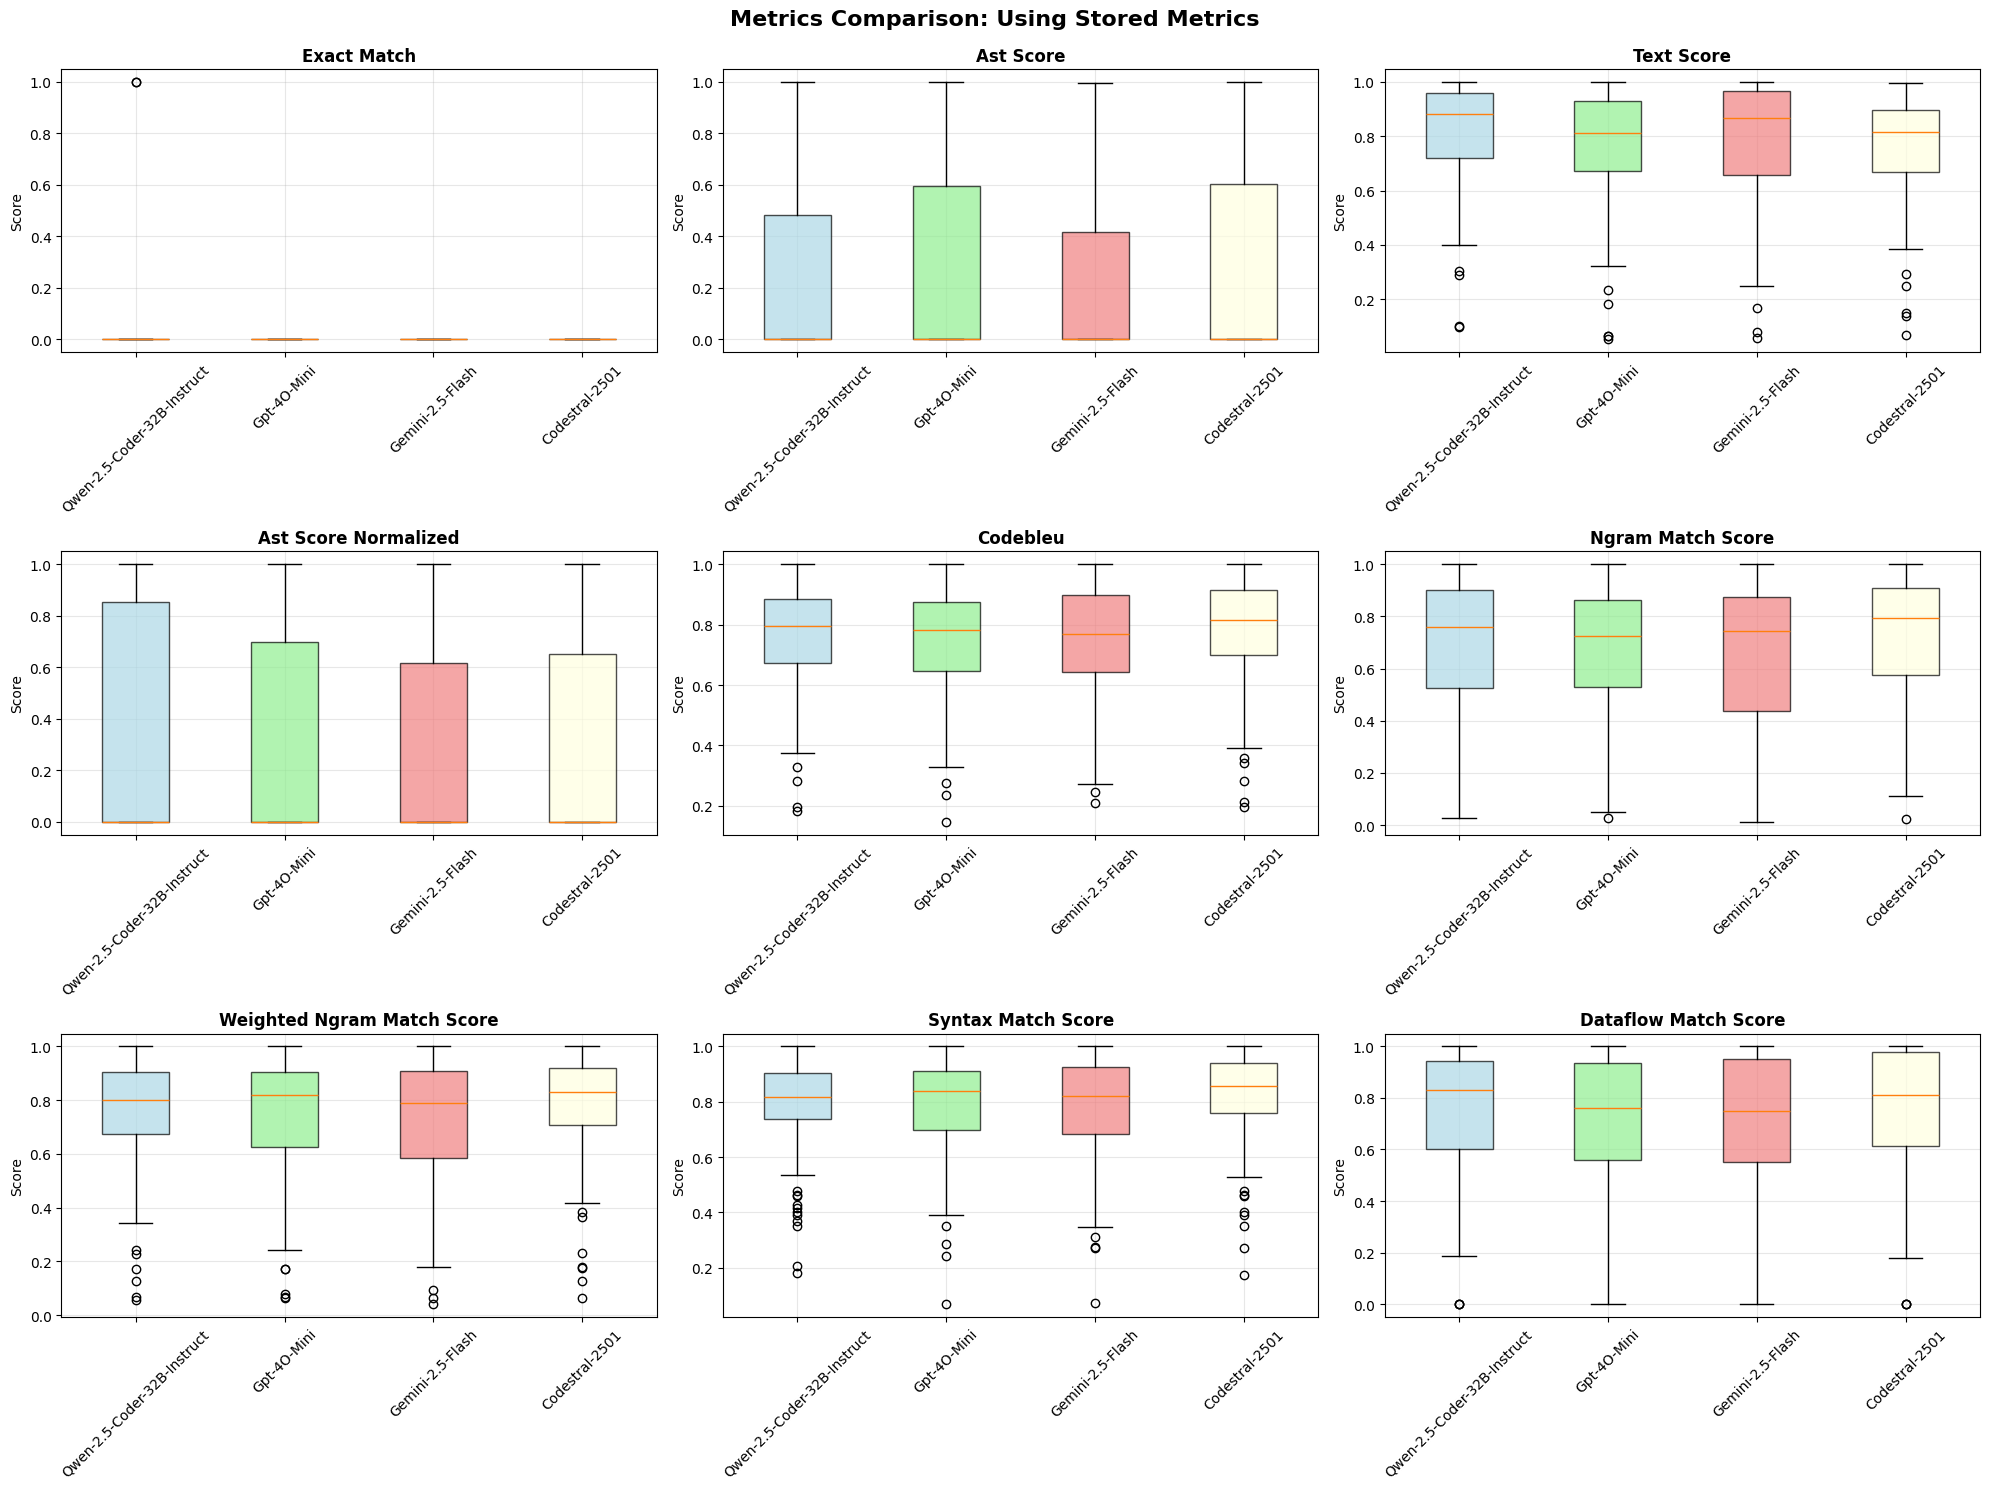


=== SUMMARY STATISTICS (FROM STORED METRICS) ===
Number of response columns: 4
Number of metrics: 9
Available metrics: ['exact_match', 'ast_score', 'text_score', 'ast_score_normalized', 'codebleu', 'ngram_match_score', 'weighted_ngram_match_score', 'syntax_match_score', 'dataflow_match_score']

Exact Match:
  Qwen-2.5-Coder-32B-Instruct: mean=0.020, std=0.141, median=0.000 (n=100)
  Gpt-4O-Mini: mean=0.000, std=0.000, median=0.000 (n=100)
  Gemini-2.5-Flash: mean=0.000, std=0.000, median=0.000 (n=100)
  Codestral-2501: mean=0.000, std=0.000, median=0.000 (n=100)

Ast Score:
  Qwen-2.5-Coder-32B-Instruct: mean=0.229, std=0.377, median=0.000 (n=100)
  Gpt-4O-Mini: mean=0.232, std=0.364, median=0.000 (n=100)
  Gemini-2.5-Flash: mean=0.213, std=0.358, median=0.000 (n=100)
  Codestral-2501: mean=0.239, std=0.380, median=0.000 (n=100)

Text Score:
  Qwen-2.5-Coder-32B-Instruct: mean=0.812, std=0.196, median=0.883 (n=100)
  Gpt-4O-Mini: mean=0.757, std=0.217, median=0.811 (n=100)
  Gemini-2.

In [13]:

plot_metrics_boxplots(
    prompt_data, reference_column="after_merge_without_docstrings")

Creating boxplots using stored metrics for 6 response columns...


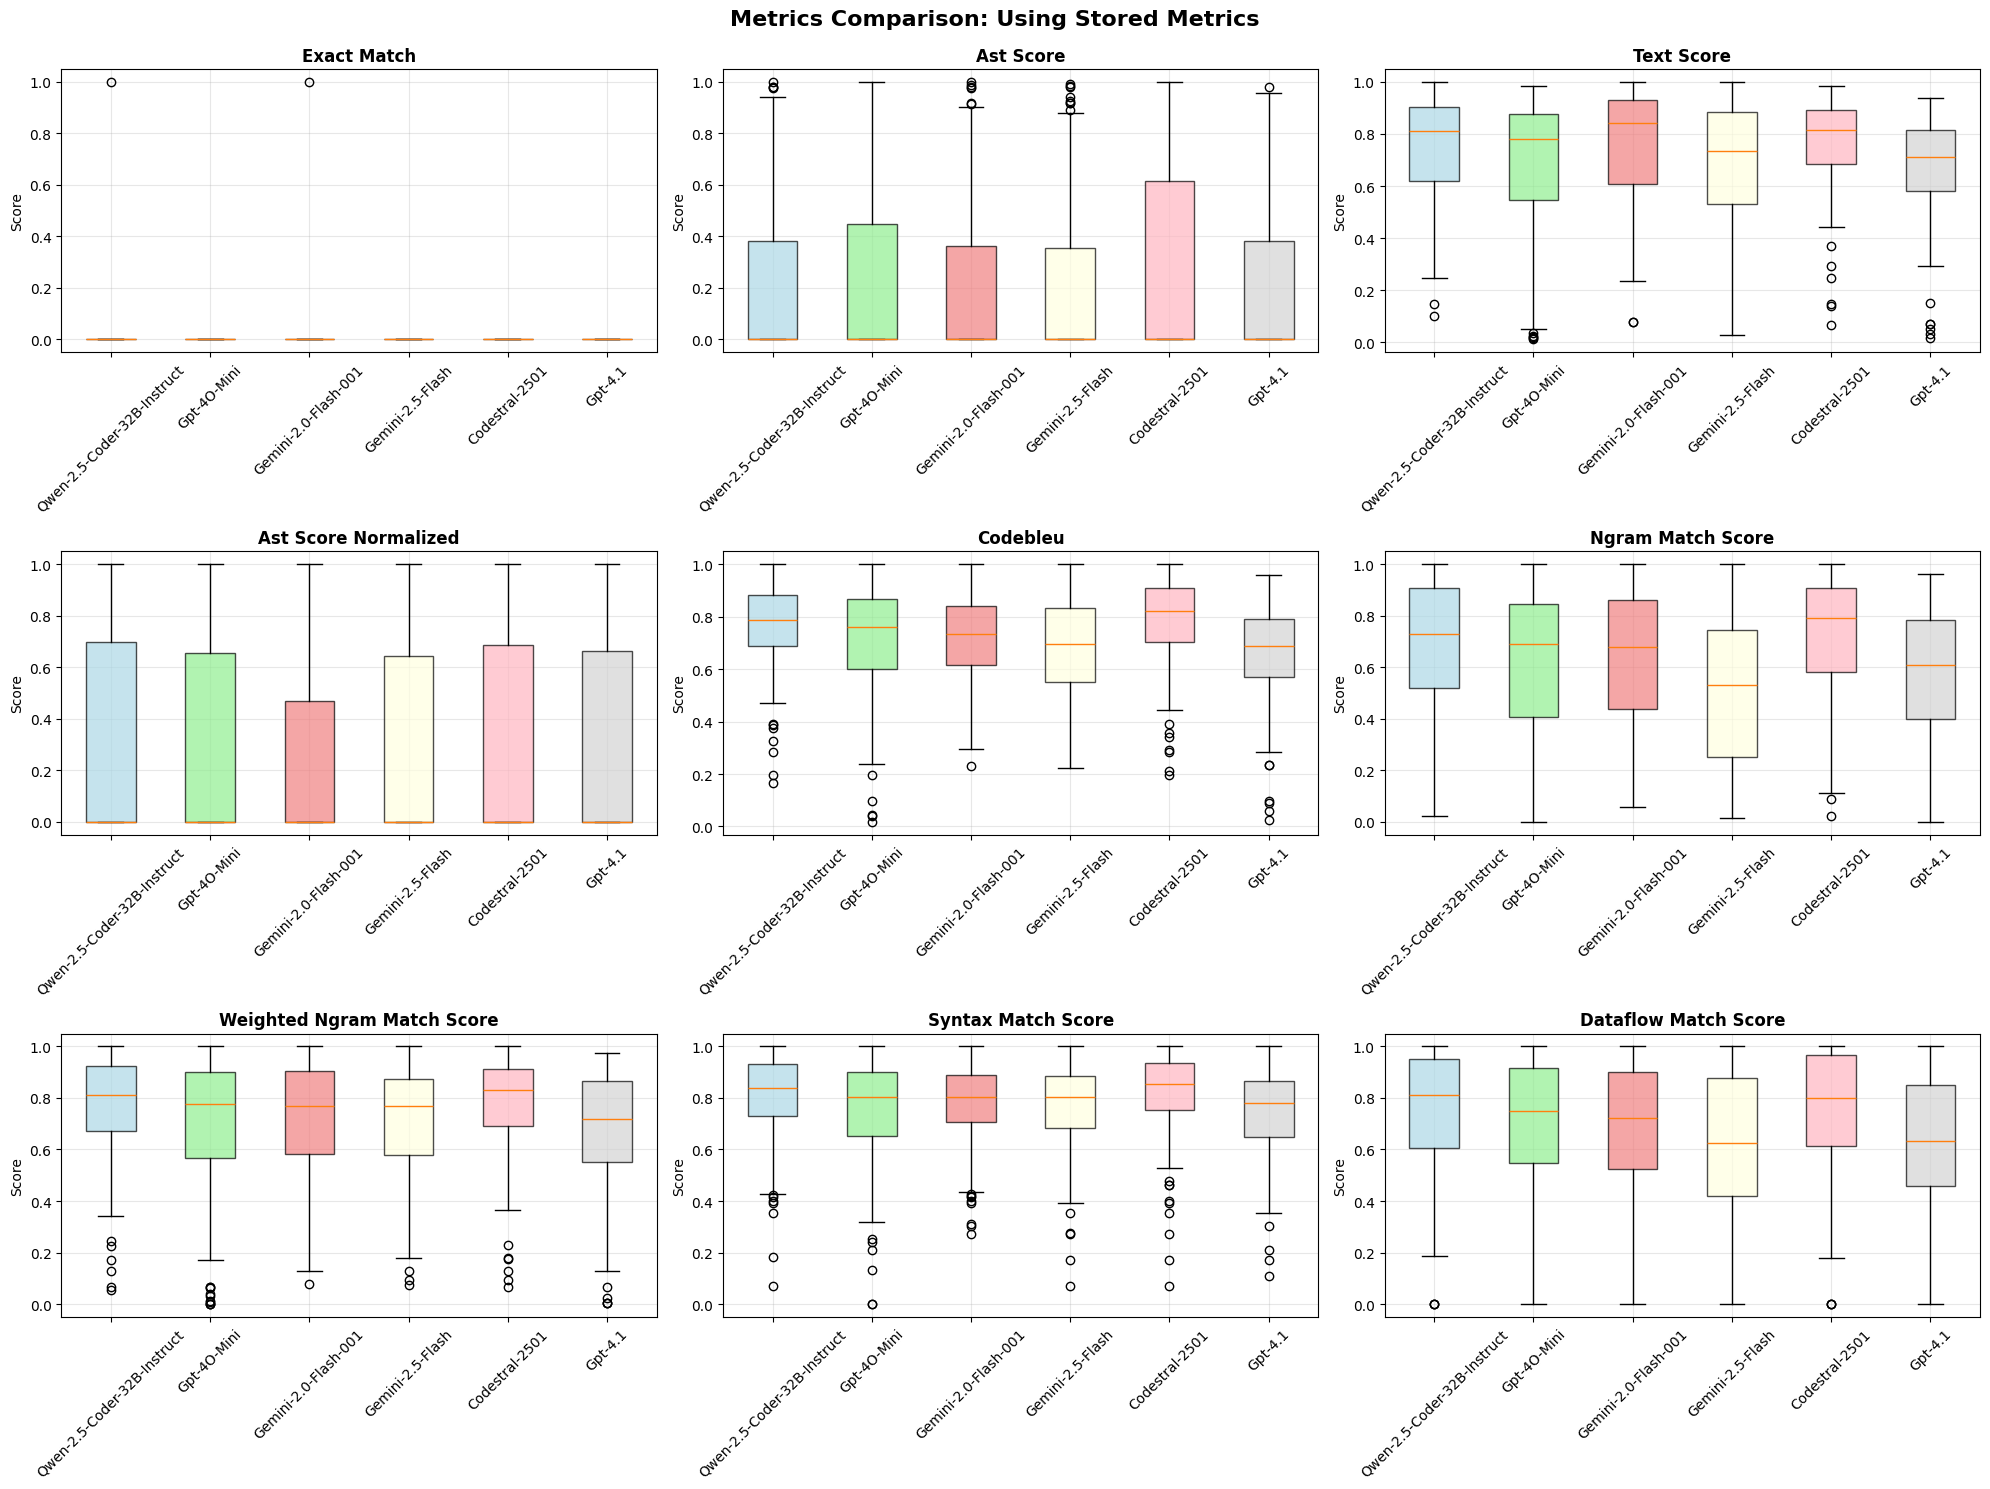


=== SUMMARY STATISTICS (FROM STORED METRICS) ===
Number of response columns: 6
Number of metrics: 9
Available metrics: ['exact_match', 'ast_score', 'text_score', 'ast_score_normalized', 'codebleu', 'ngram_match_score', 'weighted_ngram_match_score', 'syntax_match_score', 'dataflow_match_score']

Exact Match:
  Qwen-2.5-Coder-32B-Instruct: mean=0.010, std=0.100, median=0.000 (n=100)
  Gpt-4O-Mini: mean=0.000, std=0.000, median=0.000 (n=100)
  Gemini-2.0-Flash-001: mean=0.010, std=0.100, median=0.000 (n=100)
  Gemini-2.5-Flash: mean=0.000, std=0.000, median=0.000 (n=100)
  Codestral-2501: mean=0.000, std=0.000, median=0.000 (n=100)
  Gpt-4.1: mean=0.000, std=0.000, median=0.000 (n=100)

Ast Score:
  Qwen-2.5-Coder-32B-Instruct: mean=0.215, std=0.364, median=0.000 (n=100)
  Gpt-4O-Mini: mean=0.221, std=0.363, median=0.000 (n=100)
  Gemini-2.0-Flash-001: mean=0.180, std=0.319, median=0.000 (n=100)
  Gemini-2.5-Flash: mean=0.189, std=0.334, median=0.000 (n=100)
  Codestral-2501: mean=0.246,

In [ ]:
plot_metrics_boxplots(
    sample_data, reference_column="after_merge_without_docstrings")

### Syntax Match Score:
prompt = ""You are a helpful assistant that corrects the code based on the traceback error. You must respect the original code structure and the original code style""

No prompt = ""You are a helpful assistant that corrects the code based on the traceback error.""


#### Prompt 
- Qwen-2.5-Coder-32B-Instruct: mean=0.783, std=0.182, median=0.816 (n=100)
- Gpt-4O-Mini: mean=0.784, std=0.186, median=0.840 (n=100)
- Gemini-2.5-Flash: mean=0.775, std=0.193, median=0.821 (n=100)
- Codestral-2501: mean=0.814, std=0.176, median=0.856 (n=100)
#### No prompt
- Qwen-2.5-Coder-32B-Instruct: mean=0.796, std=0.188, median=0.838 (n=100)
- Gpt-4O-Mini: mean=0.741, std=0.229, median=0.804 (n=100)
- Gemini-2.0-Flash-001: mean=0.766, std=0.172, median=0.804 (n=100)
- Gemini-2.5-Flash: mean=0.757, std=0.191, median=0.805 (n=100)
- Codestral-2501: mean=0.804, std=0.190, median=0.854 (n=100)
- Gpt-4.1: mean=0.735, std=0.184, median=0.781 (n=100)

### CodeBleu
#### Prompt
- Qwen-2.5-Coder-32B-Instruct: mean=0.757, std=0.181, median=0.797 (n=100)
- Gpt-4O-Mini: mean=0.744, std=0.181, median=0.782 (n=100)
- Gemini-2.5-Flash: mean=0.728, std=0.198, median=0.768 (n=100)
- Codestral-2501: mean=0.776, std=0.184, median=0.817 (n=100)
#### No prompt
- Qwen-2.5-Coder-32B-Instruct: mean=0.756, std=0.181, median=0.786 (n=100)
- Gpt-4O-Mini: mean=0.703, std=0.225, median=0.761 (n=100)
- Gemini-2.0-Flash-001: mean=0.716, std=0.172, median=0.732 (n=100)
- Gemini-2.5-Flash: mean=0.678, std=0.187, median=0.698 (n=100)
- Codestral-2501: mean=0.771, std=0.187, median=0.822 (n=100)
- Gpt-4.1: mean=0.661, std=0.196, median=0.688 (n=100)

In [ ]:
# print(sample_data["before_merge_without_docstrings"].iloc[0])
assert sample_data["before_merge_without_docstrings"].to_list() == prompt_data["before_merge_without_docstrings"].to_list()

AssertionError: 

In [26]:
print(prompt_data["before_merge_without_docstrings"].iloc[0])


    async def stop_notify(self, _uuid: str) -> None:
        
        char_props = self.characteristics.get(_uuid)
        await self._bus.callRemote(
            char_props.get("Path"),
            "StopNotify",
            interface=defs.GATT_CHARACTERISTIC_INTERFACE,
            destination=defs.BLUEZ_SERVICE,
            signature="",
            body=[],
            returnSignature="",
        ).asFuture(self.loop)
        self._notification_callbacks.pop(char_props.get("Path"), None)


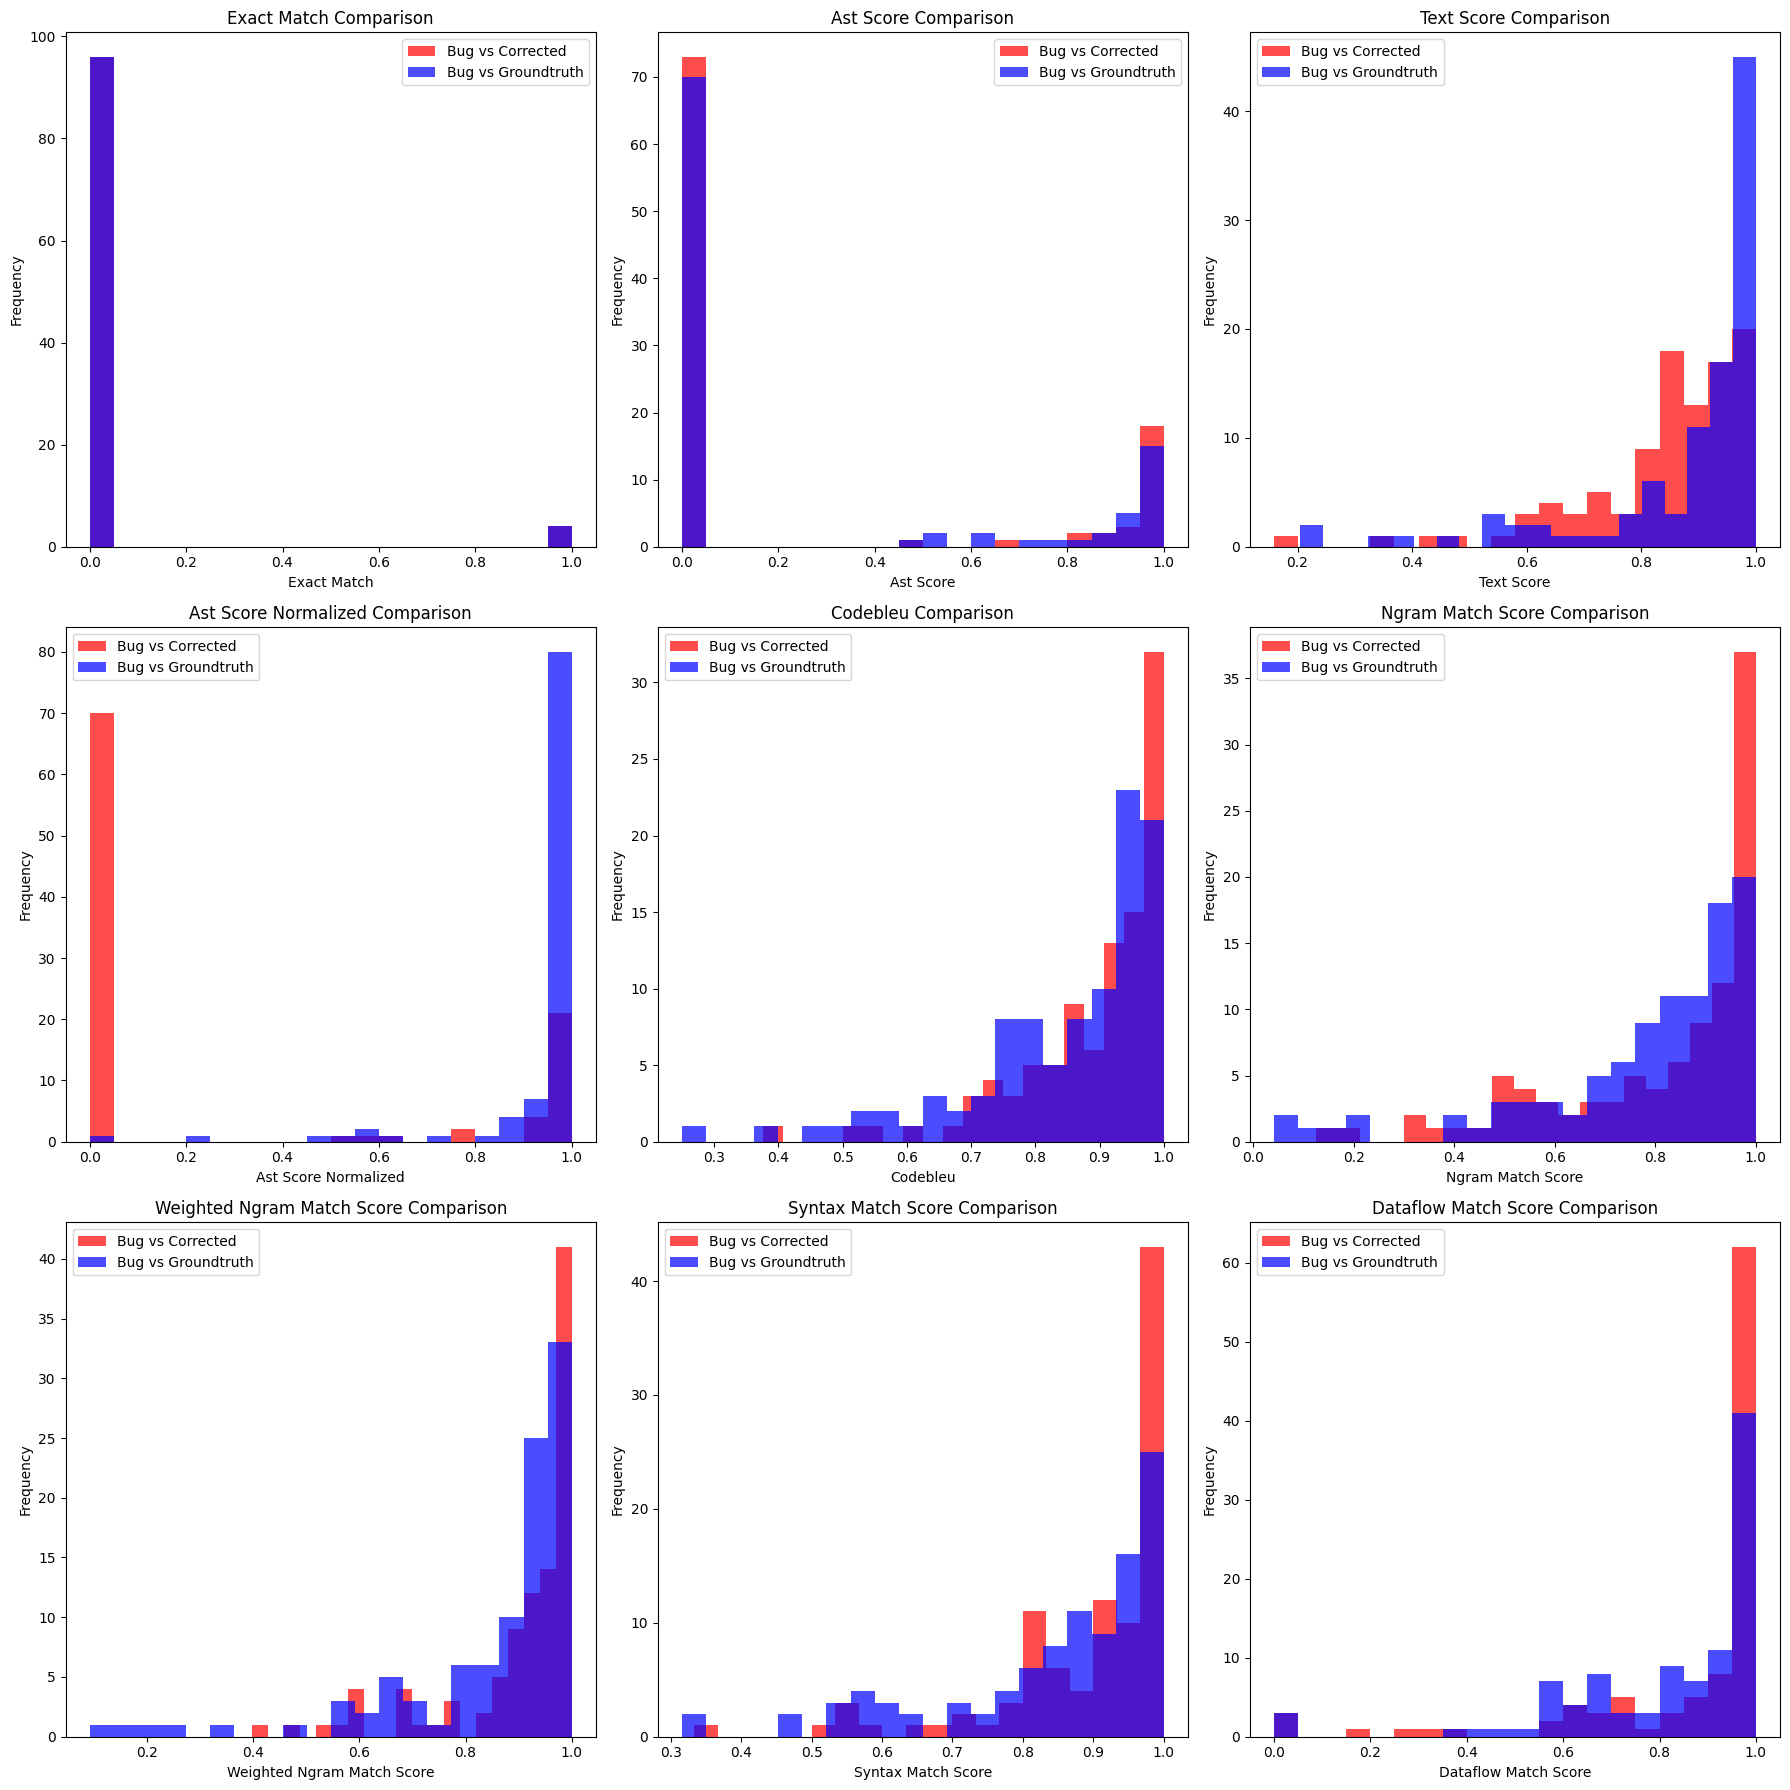

=== ALL METRICS STATISTICS ===
Exact Match - Bug vs Corrected: mean=0.040, std=0.196
Exact Match - Bug vs Groundtruth: mean=0.040, std=0.196
Ast Score - Bug vs Corrected: mean=0.251, std=0.417
Ast Score - Bug vs Groundtruth: mean=0.262, std=0.410
Text Score - Bug vs Corrected: mean=0.845, std=0.149
Text Score - Bug vs Groundtruth: mean=0.879, std=0.174
Ast Score Normalized - Bug vs Corrected: mean=0.278, std=0.431
Ast Score Normalized - Bug vs Groundtruth: mean=0.944, std=0.157
Codebleu - Bug vs Corrected: mean=0.893, std=0.116
Codebleu - Bug vs Groundtruth: mean=0.848, std=0.150
Ngram Match Score - Bug vs Corrected: mean=0.817, std=0.206
Ngram Match Score - Bug vs Groundtruth: mean=0.785, std=0.221
Weighted Ngram Match Score - Bug vs Corrected: mean=0.901, std=0.135
Weighted Ngram Match Score - Bug vs Groundtruth: mean=0.852, std=0.191
Syntax Match Score - Bug vs Corrected: mean=0.898, std=0.131
Syntax Match Score - Bug vs Groundtruth: mean=0.847, std=0.160
Dataflow Match Score - Bug 

In [15]:
compare_metrics_versus_bug_histograms(sample_data['before_merge_without_docstrings'],
                                      sample_data['after_merge_without_docstrings'], sample_data['response_qwen-2.5-coder-32b-instruct'])

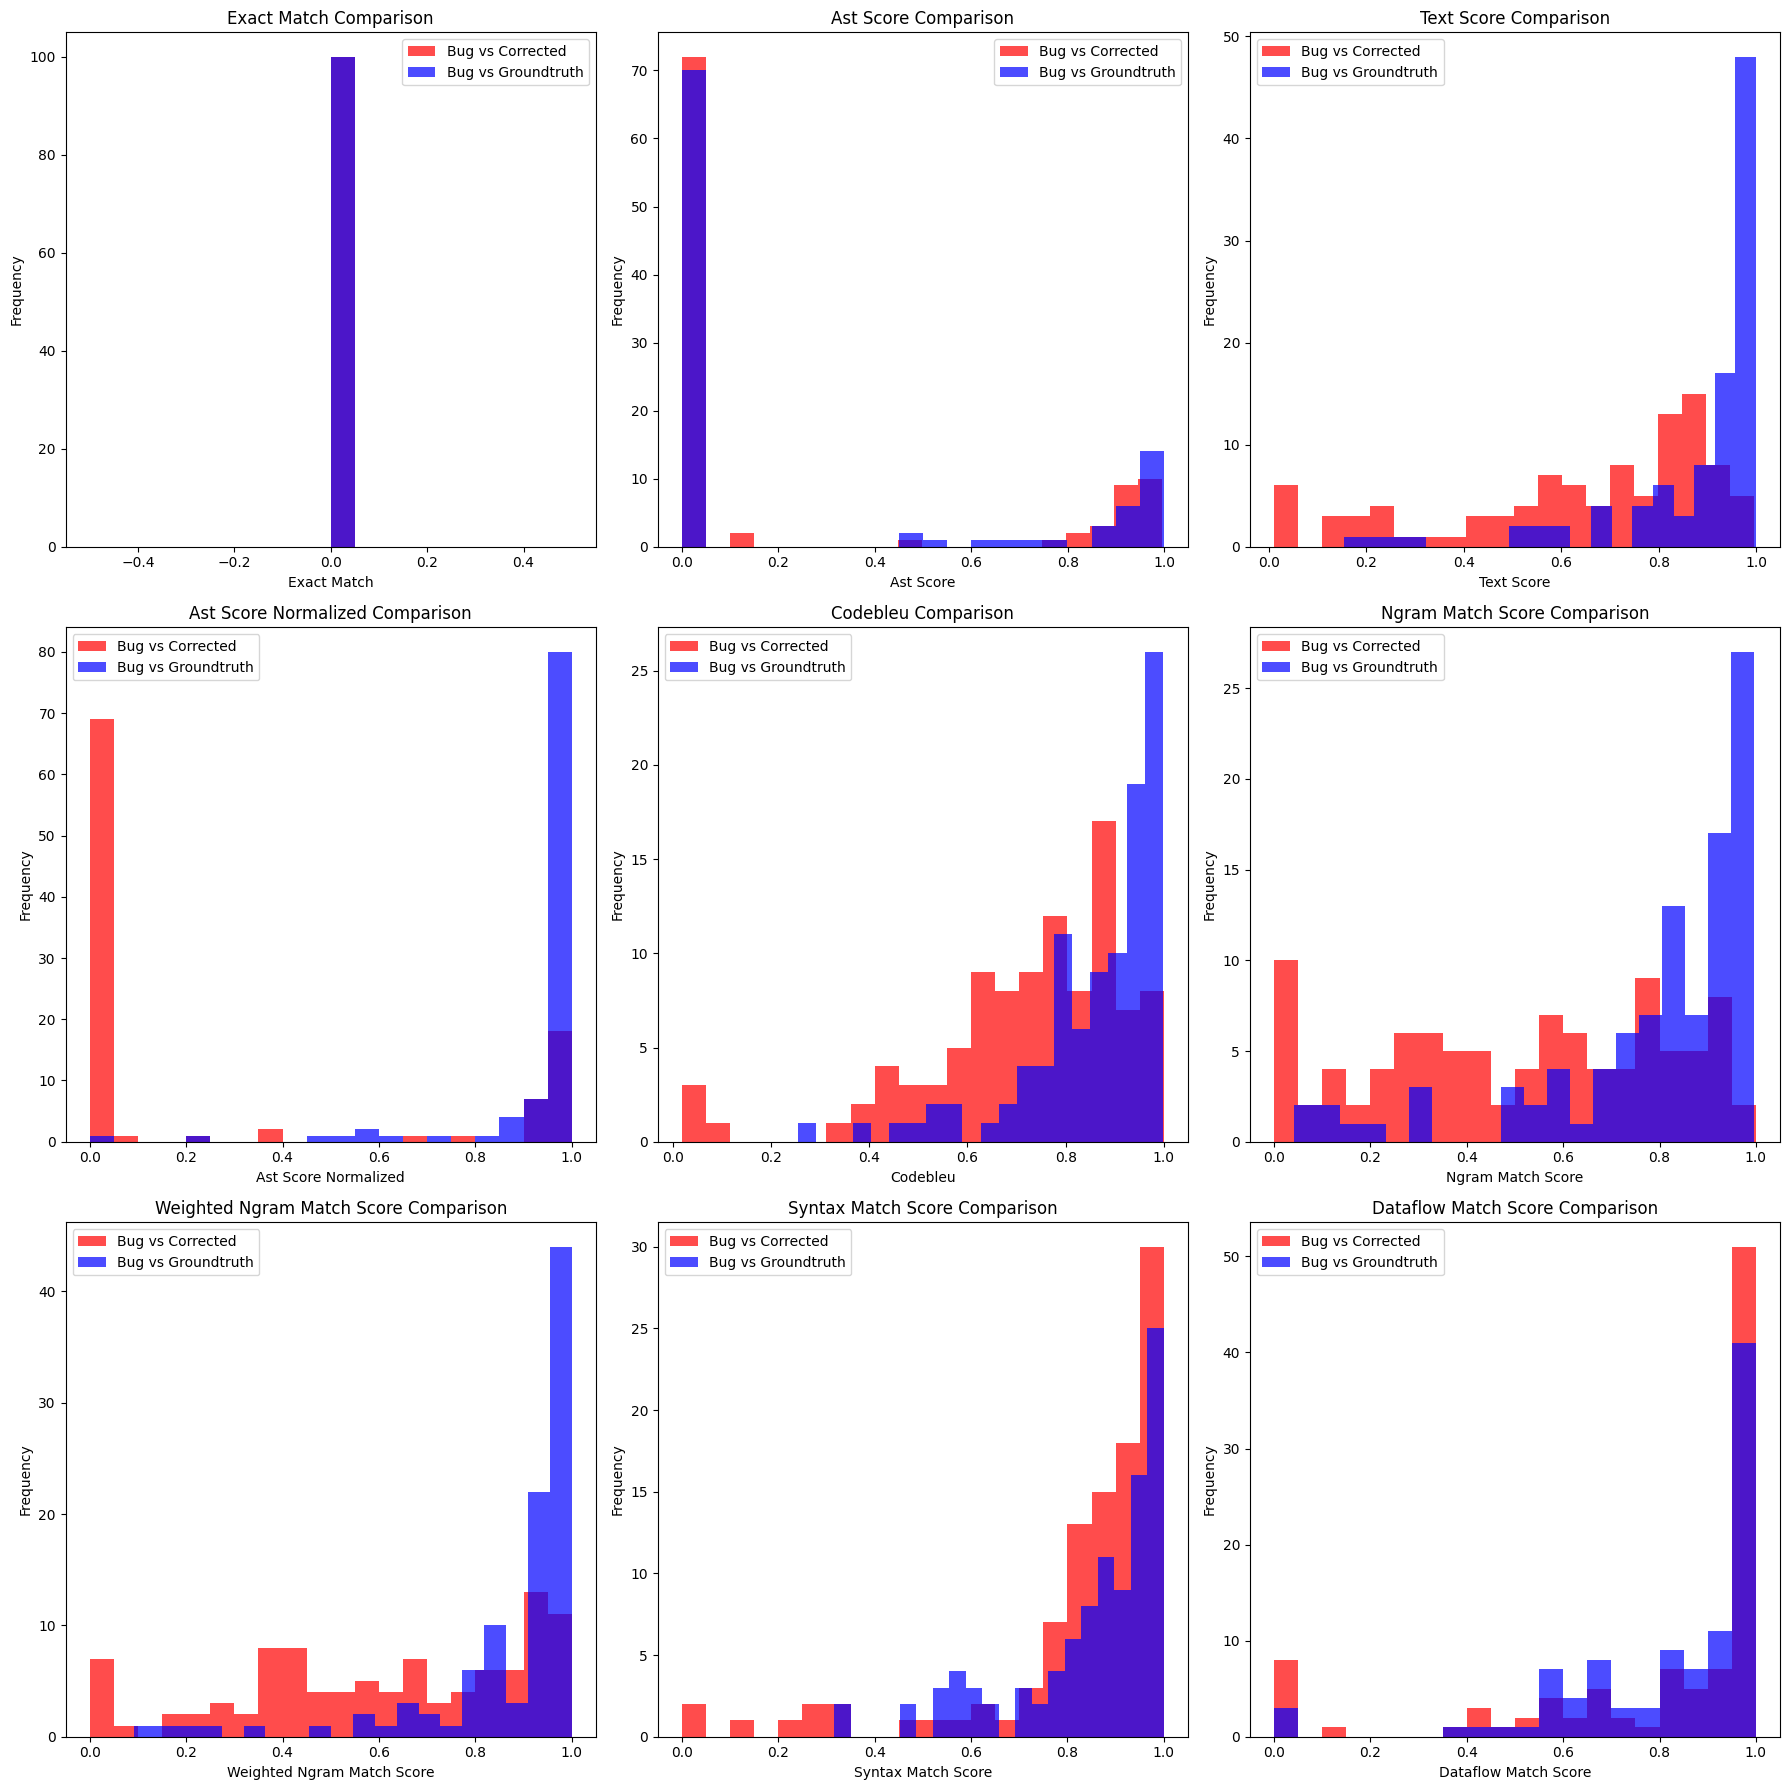

=== ALL METRICS STATISTICS ===
Exact Match - Bug vs Corrected: mean=0.000, std=0.000
Exact Match - Bug vs Groundtruth: mean=0.000, std=0.000
Ast Score - Bug vs Corrected: mean=0.239, std=0.401
Ast Score - Bug vs Groundtruth: mean=0.262, std=0.410
Text Score - Bug vs Corrected: mean=0.640, std=0.274
Text Score - Bug vs Groundtruth: mean=0.879, std=0.176
Ast Score Normalized - Bug vs Corrected: mean=0.269, std=0.423
Ast Score Normalized - Bug vs Groundtruth: mean=0.945, std=0.157
Codebleu - Bug vs Corrected: mean=0.719, std=0.208
Codebleu - Bug vs Groundtruth: mean=0.855, std=0.145
Ngram Match Score - Bug vs Corrected: mean=0.509, std=0.294
Ngram Match Score - Bug vs Groundtruth: mean=0.789, std=0.232
Weighted Ngram Match Score - Bug vs Corrected: mean=0.613, std=0.291
Weighted Ngram Match Score - Bug vs Groundtruth: mean=0.870, std=0.188
Syntax Match Score - Bug vs Corrected: mean=0.827, std=0.219
Syntax Match Score - Bug vs Groundtruth: mean=0.847, std=0.160
Dataflow Match Score - Bug 

In [16]:
compare_metrics_versus_bug_histograms(
    sample_data['before_merge'], sample_data['after_merge'], sample_data['response_gpt-4o-mini'])

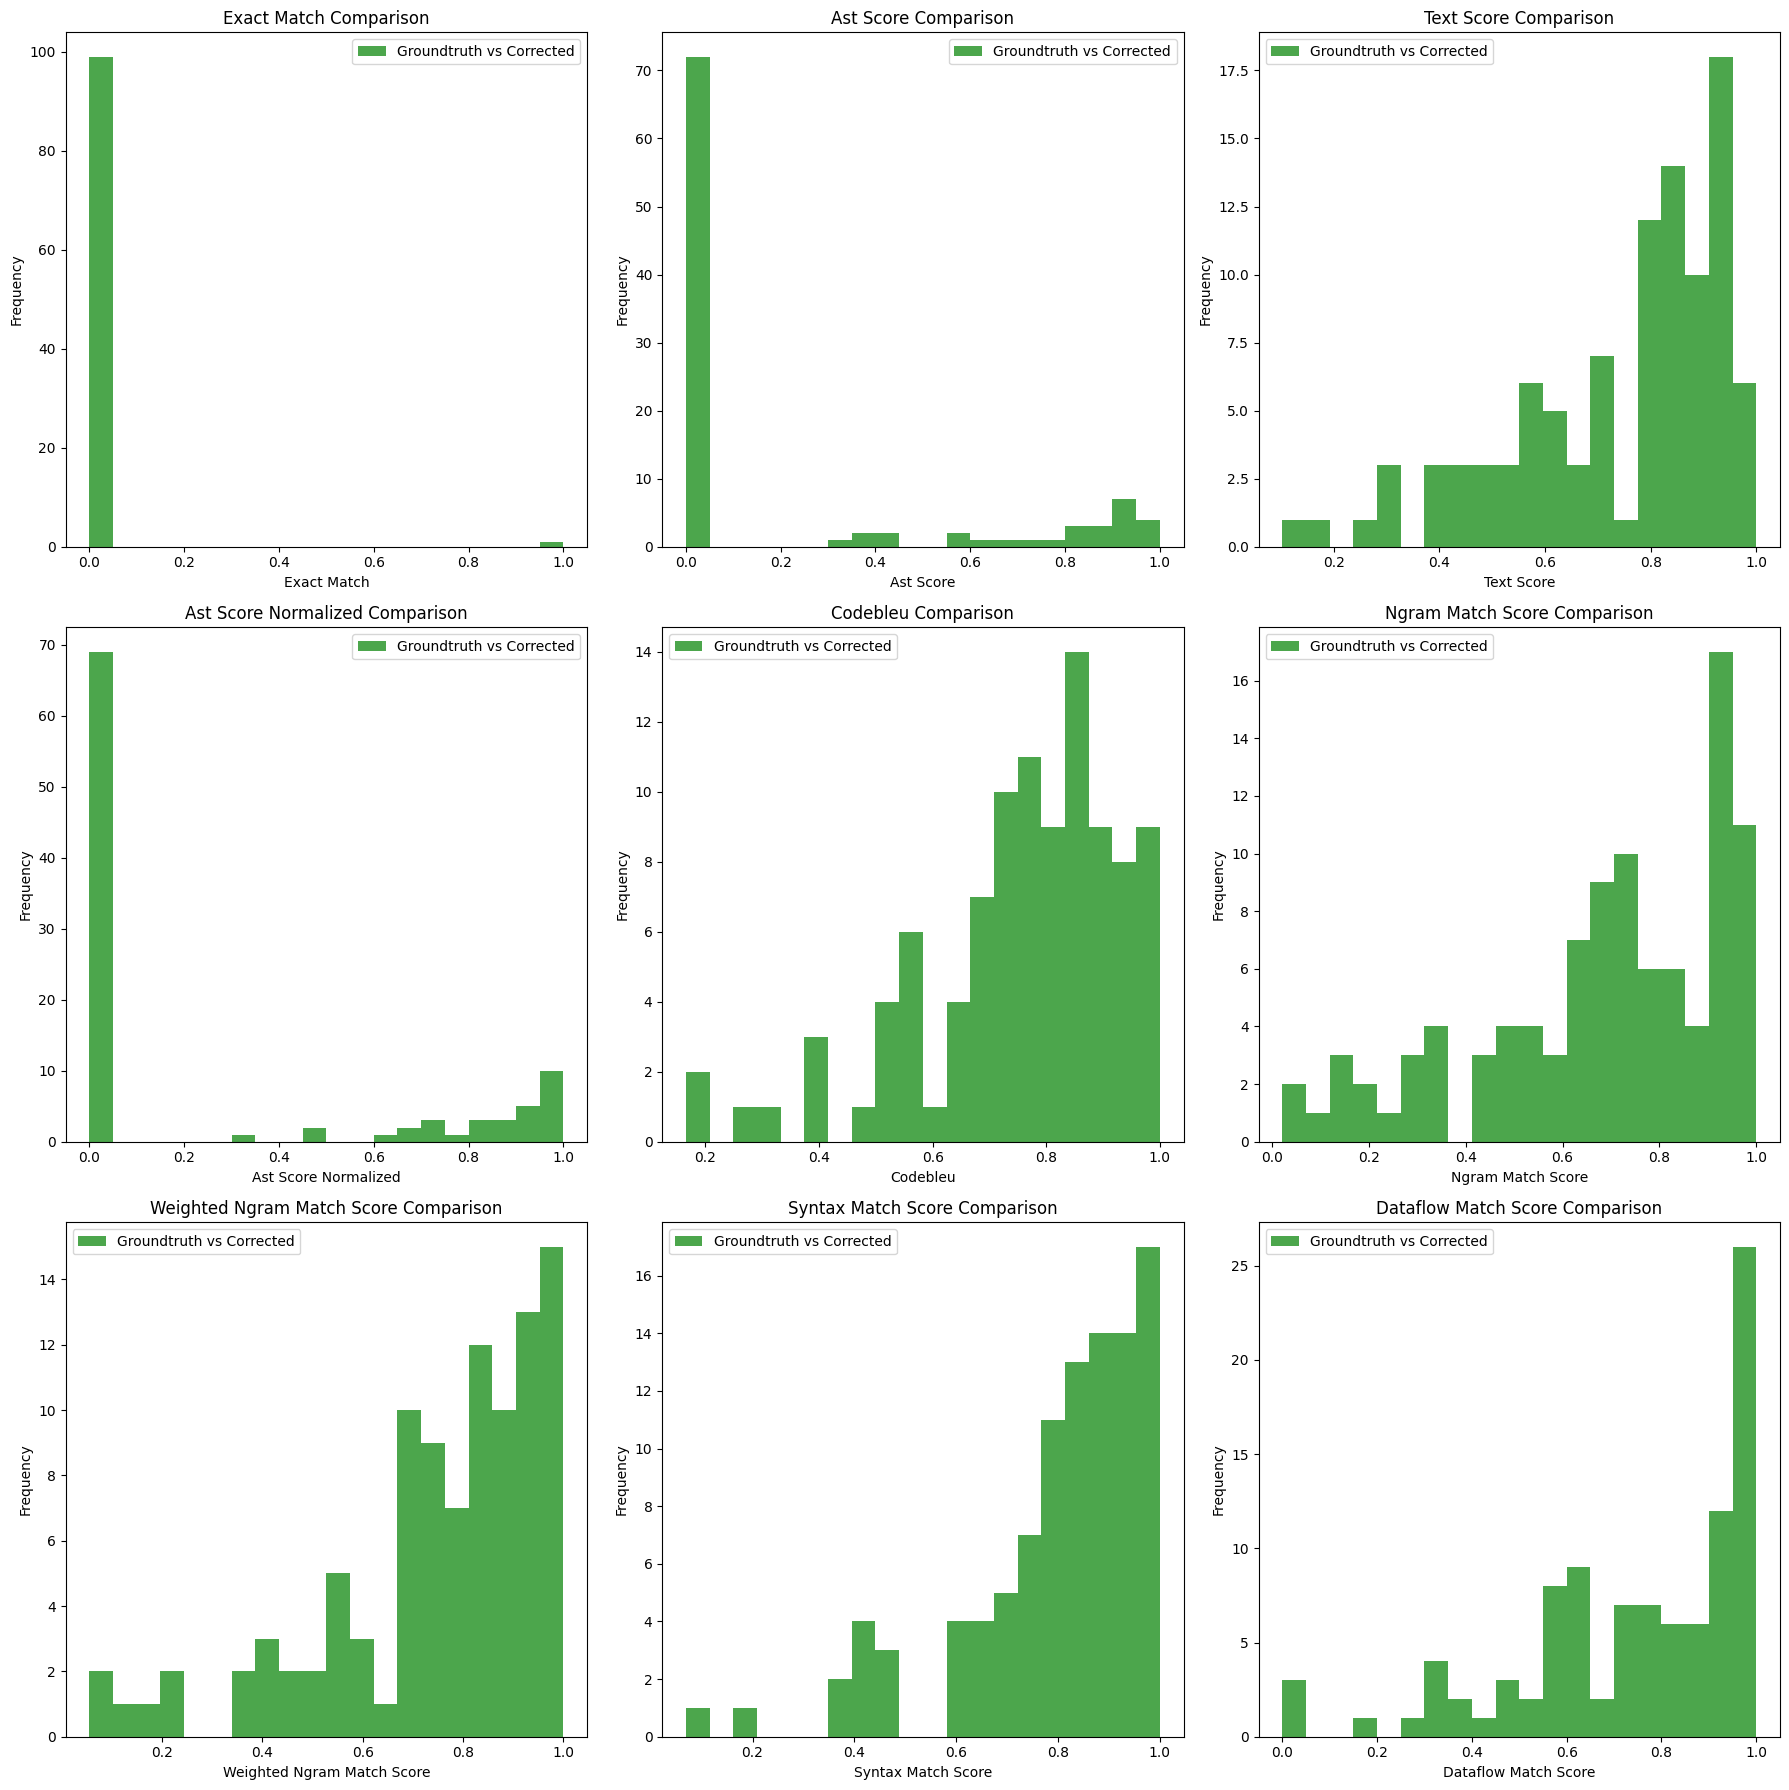

=== GROUNDTRUTH VS CORRECTED METRICS STATISTICS ===
Exact Match - Groundtruth vs Corrected: mean=0.010, std=0.099
Ast Score - Groundtruth vs Corrected: mean=0.215, std=0.363
Text Score - Groundtruth vs Corrected: mean=0.743, std=0.205
Ast Score Normalized - Groundtruth vs Corrected: mean=0.259, std=0.398
Codebleu - Groundtruth vs Corrected: mean=0.757, std=0.180
Ngram Match Score - Groundtruth vs Corrected: mean=0.682, std=0.256
Weighted Ngram Match Score - Groundtruth vs Corrected: mean=0.749, std=0.224
Syntax Match Score - Groundtruth vs Corrected: mean=0.796, std=0.187
Dataflow Match Score - Groundtruth vs Corrected: mean=0.744, std=0.245


In [17]:
compare_groundtruth_vs_corrected_histograms(
    sample_data['after_merge_without_docstrings'], sample_data['response_qwen-2.5-coder-32b-instruct'])

#### qwen

Exact Match - Groundtruth vs Corrected: mean=0.010, std=0.099
Ast Score - Groundtruth vs Corrected: mean=0.201, std=0.346
Text Score - Groundtruth vs Corrected: mean=0.734, std=0.208
Ast Score Normalized - Groundtruth vs Corrected: mean=0.237, std=0.382
Codebleu - Groundtruth vs Corrected: mean=0.733, std=0.197
Ngram Match Score - Groundtruth vs Corrected: mean=0.644, std=0.298
Weighted Ngram Match Score - Groundtruth vs Corrected: mean=0.706, std=0.258
Syntax Match Score - Groundtruth vs Corrected: mean=0.783, std=0.189
Dataflow Match Score - Groundtruth vs Corrected: mean=0.739, std=0.257

#### gpt

Exact Match - Groundtruth vs Corrected: mean=0.000, std=0.000
Ast Score - Groundtruth vs Corrected: mean=0.200, std=0.347
Text Score - Groundtruth vs Corrected: mean=0.652, std=0.274
Ast Score Normalized - Groundtruth vs Corrected: mean=0.253, std=0.390
Codebleu - Groundtruth vs Corrected: mean=0.662, std=0.226
Ngram Match Score - Groundtruth vs Corrected: mean=0.547, std=0.322
Weighted Ngram Match Score - Groundtruth vs Corrected: mean=0.623, std=0.308
Syntax Match Score - Groundtruth vs Corrected: mean=0.740, std=0.230
Dataflow Match Score - Groundtruth vs Corrected: mean=0.660, std=0.290

Boxplot pra cada modelo vs gt lado a lado
adicionar modelos de tamanho similares.

sera que se eu pedir (mudança de prompt) para ele fixar o estilo ele perde a corretude no bug

add mais 2 modelos (pequeno e medio)


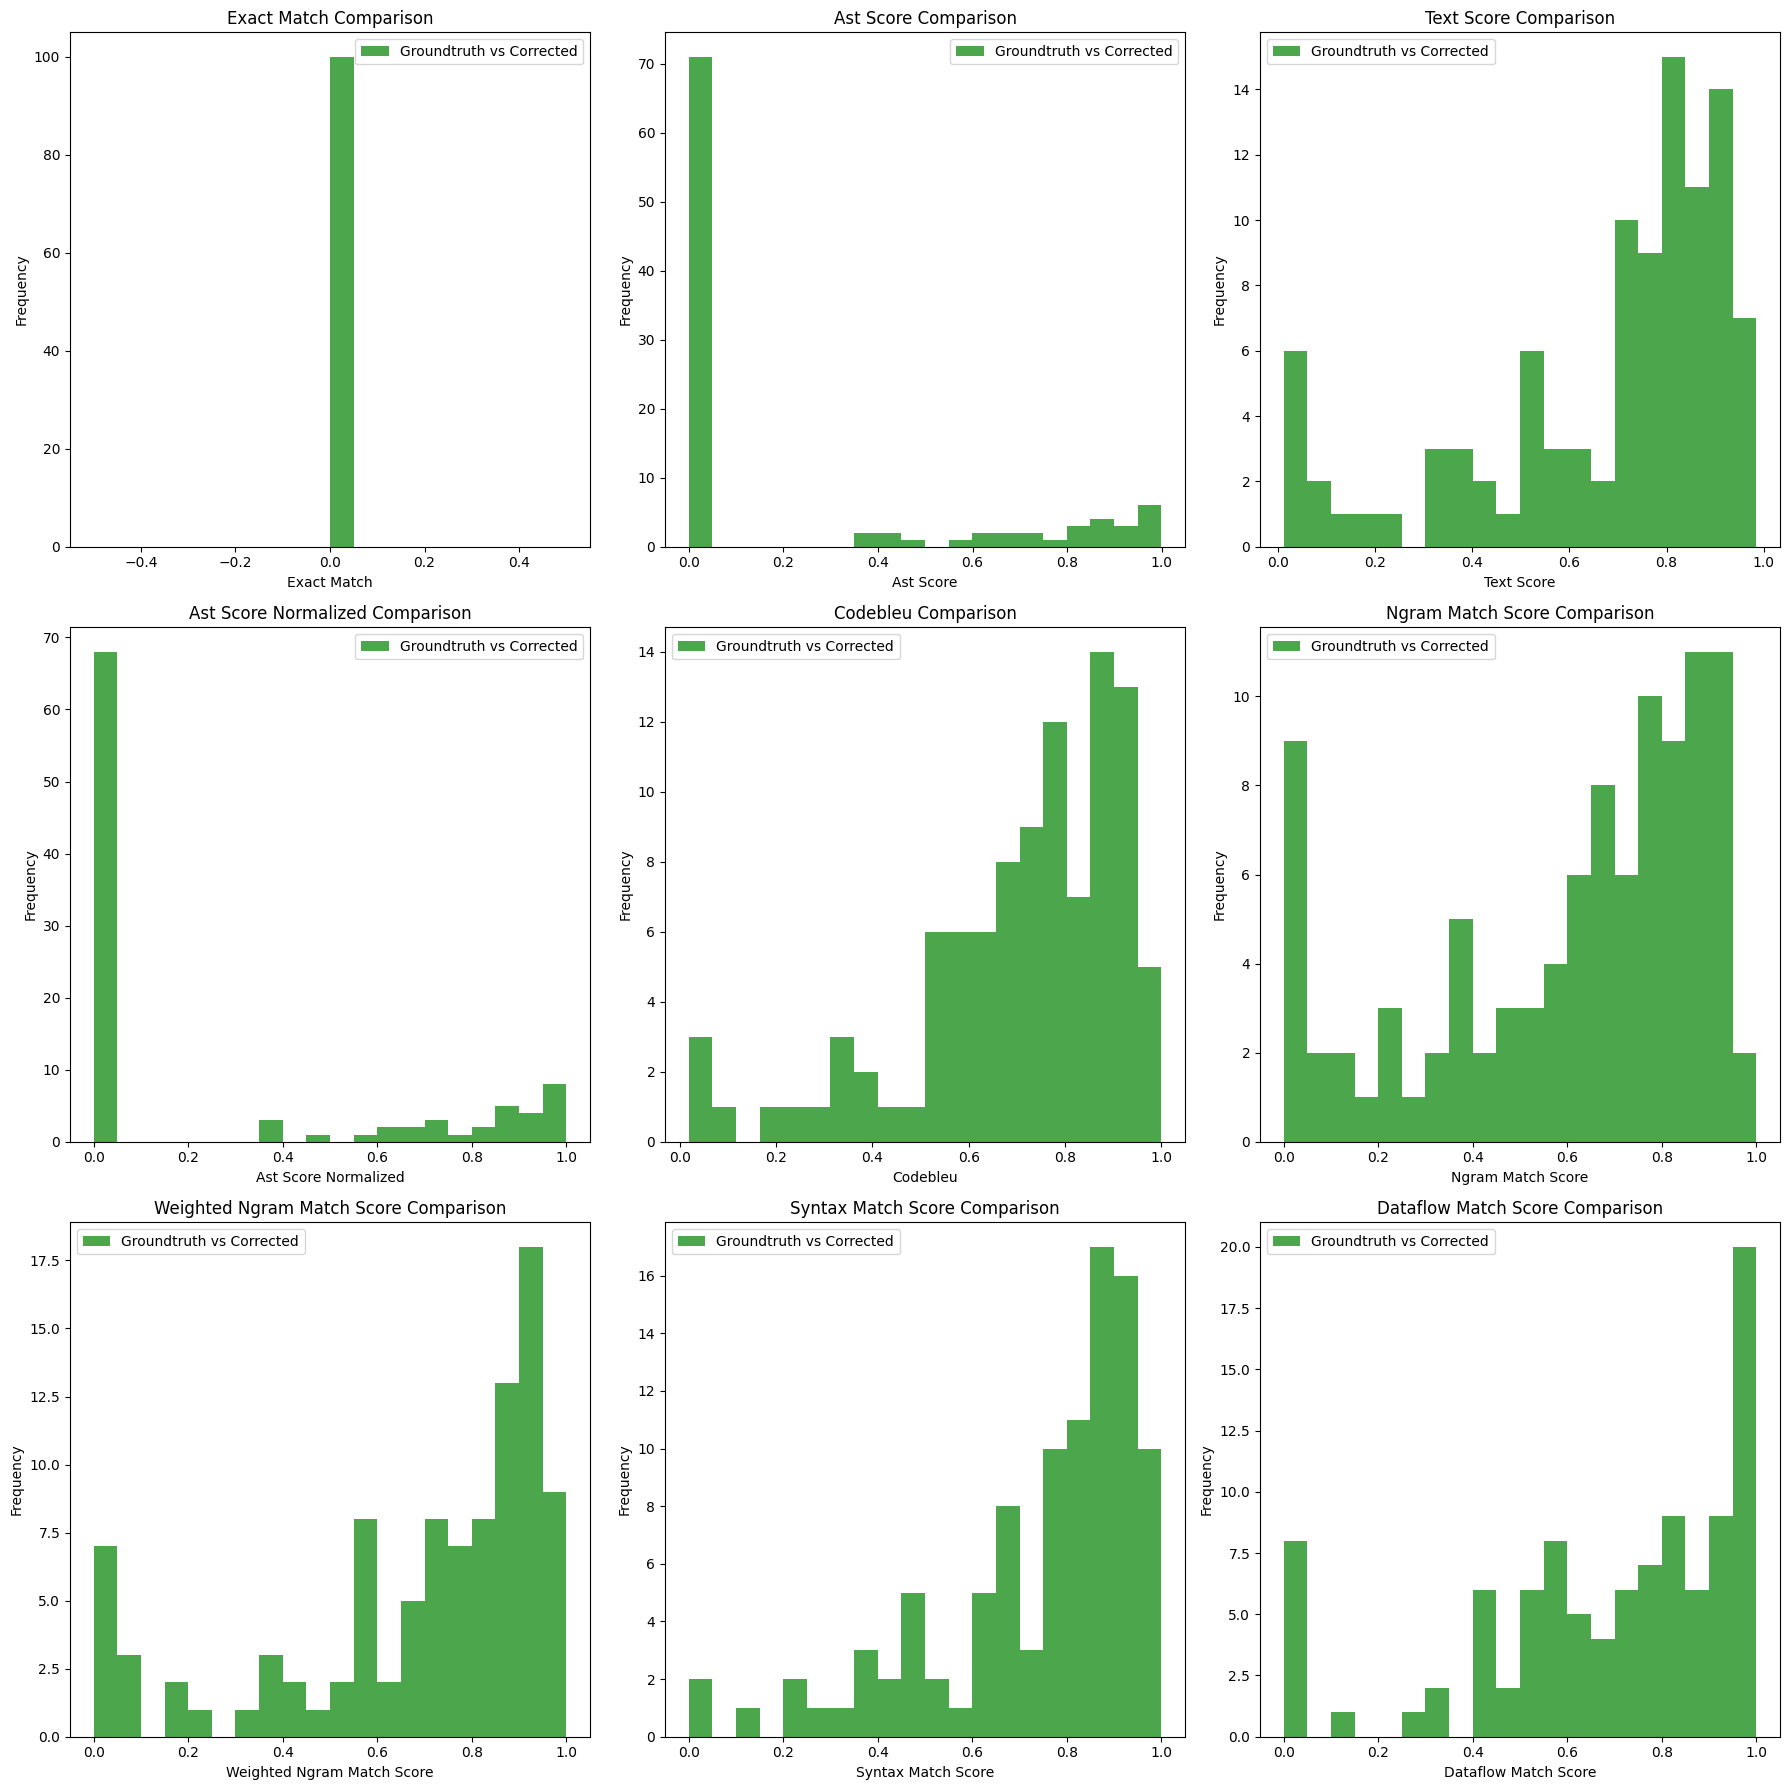

=== GROUNDTRUTH VS CORRECTED METRICS STATISTICS ===
Exact Match - Groundtruth vs Corrected: mean=0.000, std=0.000
Ast Score - Groundtruth vs Corrected: mean=0.221, std=0.362
Text Score - Groundtruth vs Corrected: mean=0.678, std=0.267
Ast Score Normalized - Groundtruth vs Corrected: mean=0.254, std=0.386
Codebleu - Groundtruth vs Corrected: mean=0.704, std=0.223
Ngram Match Score - Groundtruth vs Corrected: mean=0.605, std=0.291
Weighted Ngram Match Score - Groundtruth vs Corrected: mean=0.685, std=0.287
Syntax Match Score - Groundtruth vs Corrected: mean=0.741, std=0.228
Dataflow Match Score - Groundtruth vs Corrected: mean=0.688, std=0.282


In [18]:
compare_groundtruth_vs_corrected_histograms(
    sample_data['after_merge_without_docstrings'], sample_data['response_gpt-4o-mini'])

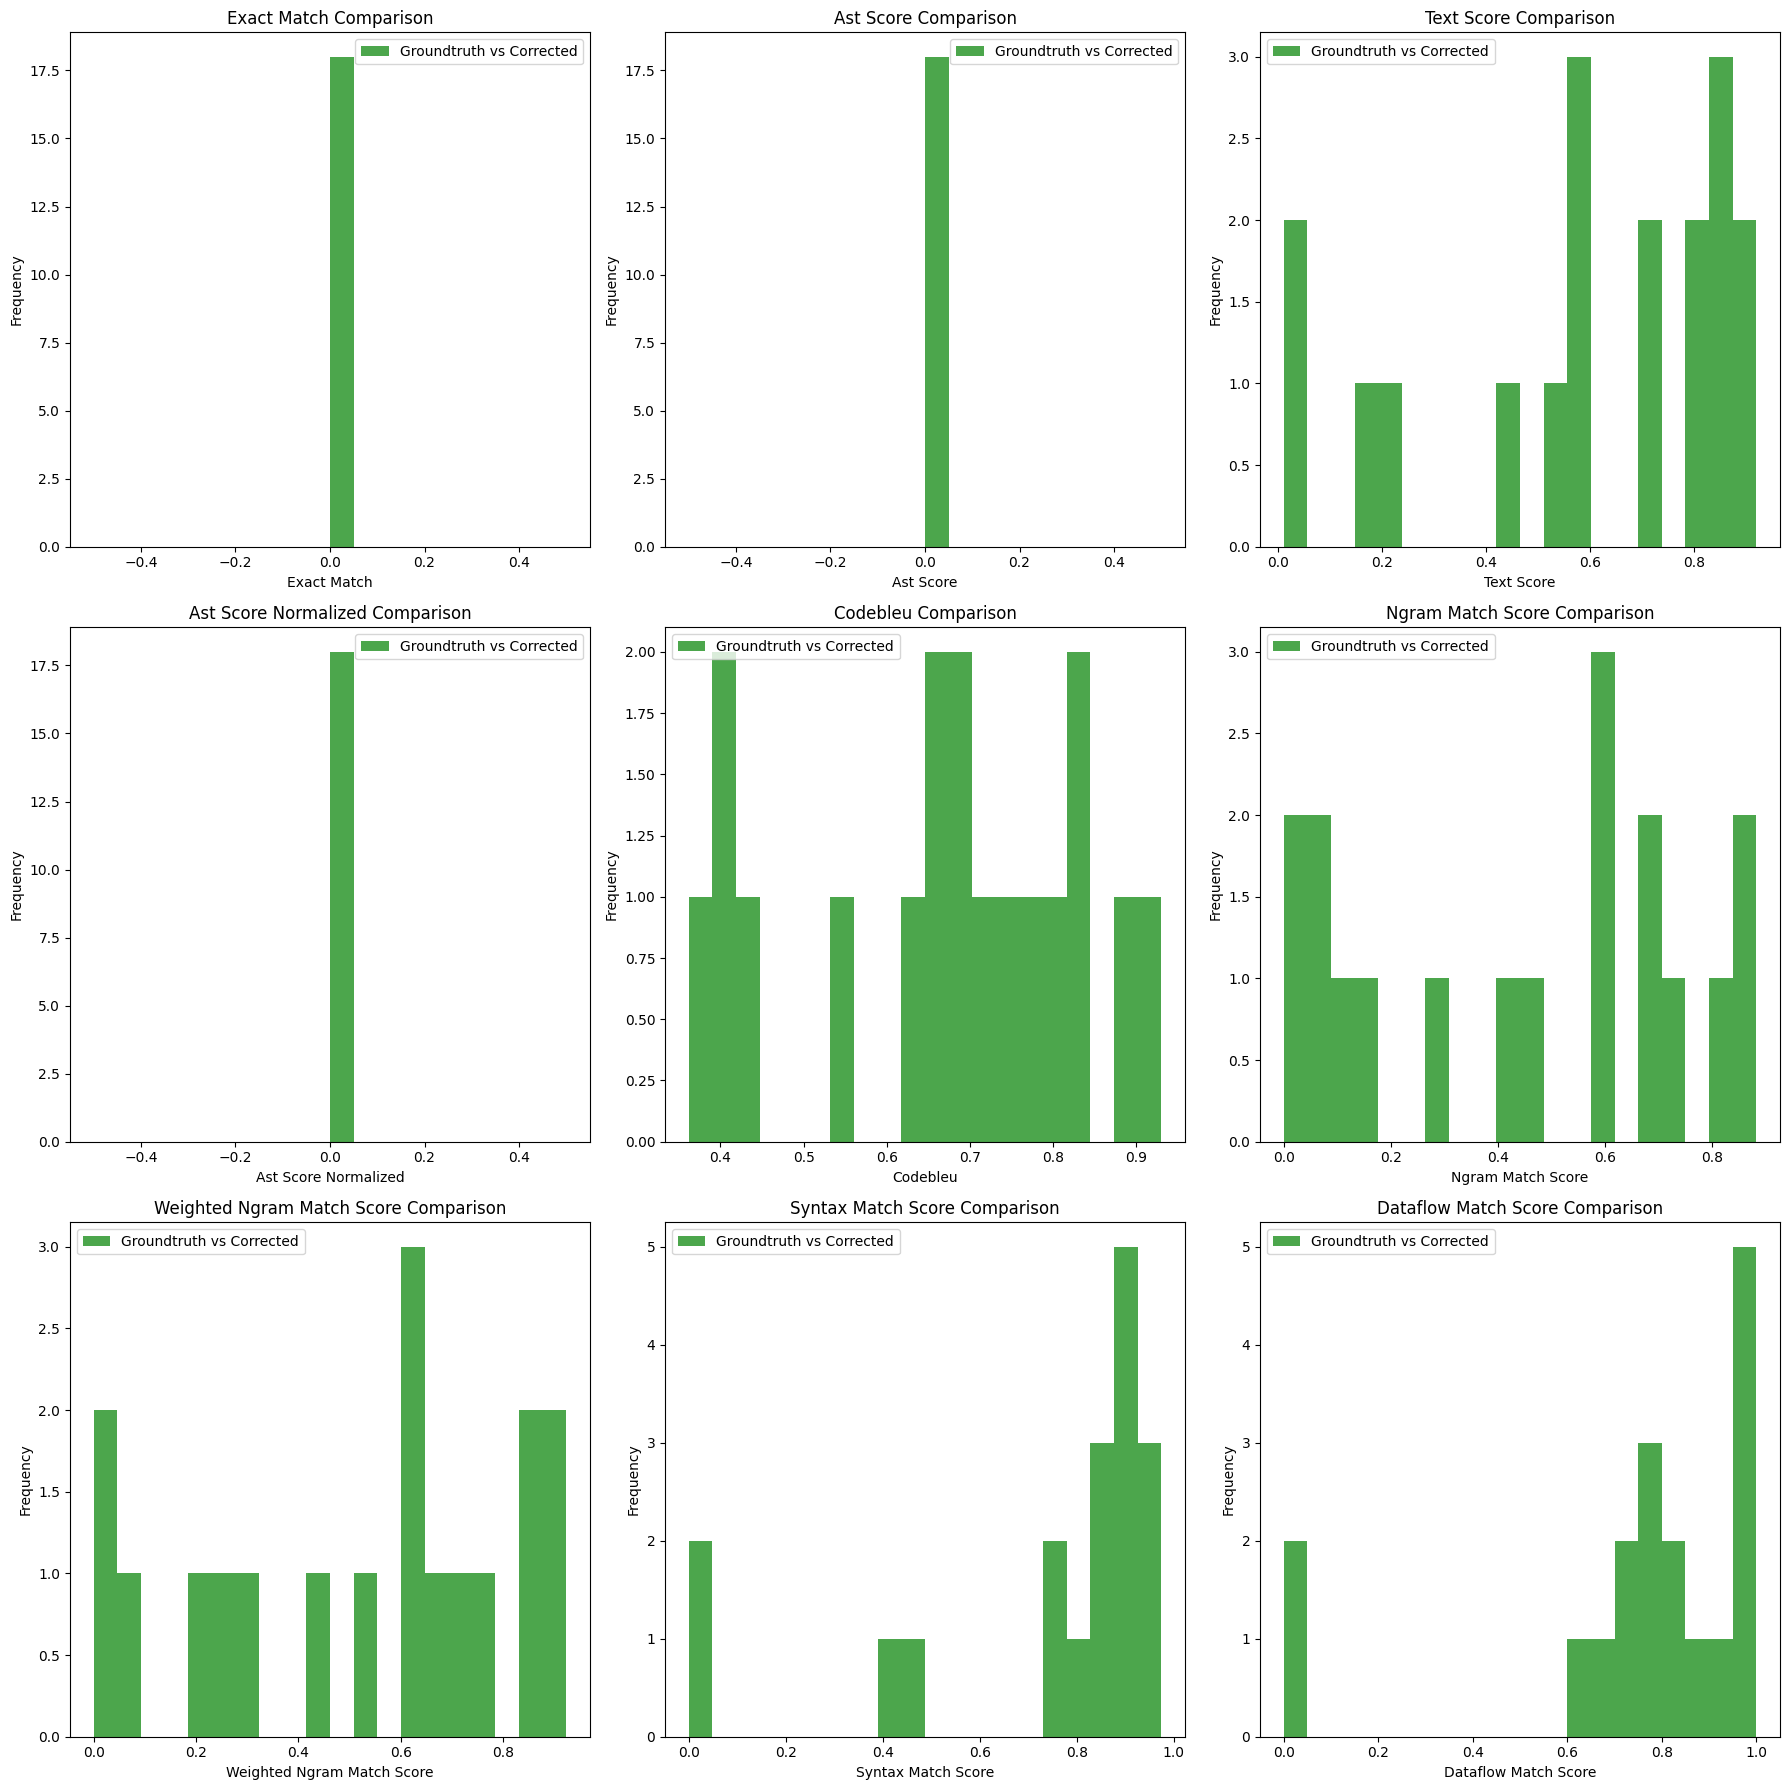

=== GROUNDTRUTH VS CORRECTED METRICS STATISTICS ===
Exact Match - Groundtruth vs Corrected: mean=0.000, std=0.000
Ast Score - Groundtruth vs Corrected: mean=0.000, std=0.000
Text Score - Groundtruth vs Corrected: mean=0.587, std=0.287
Ast Score Normalized - Groundtruth vs Corrected: mean=0.000, std=0.000
Codebleu - Groundtruth vs Corrected: mean=0.667, std=0.170
Ngram Match Score - Groundtruth vs Corrected: mean=0.446, std=0.305
Weighted Ngram Match Score - Groundtruth vs Corrected: mean=0.517, std=0.299
Syntax Match Score - Groundtruth vs Corrected: mean=0.725, std=0.298
Dataflow Match Score - Groundtruth vs Corrected: mean=0.748, std=0.290


In [19]:
compare_groundtruth_vs_corrected_histograms(sample_data[sample_data['traceback_type'] == 'AttributeError']
                                            ['after_merge'], sample_data[sample_data['traceback_type'] == 'AttributeError']['response_gpt-4o-mini'])

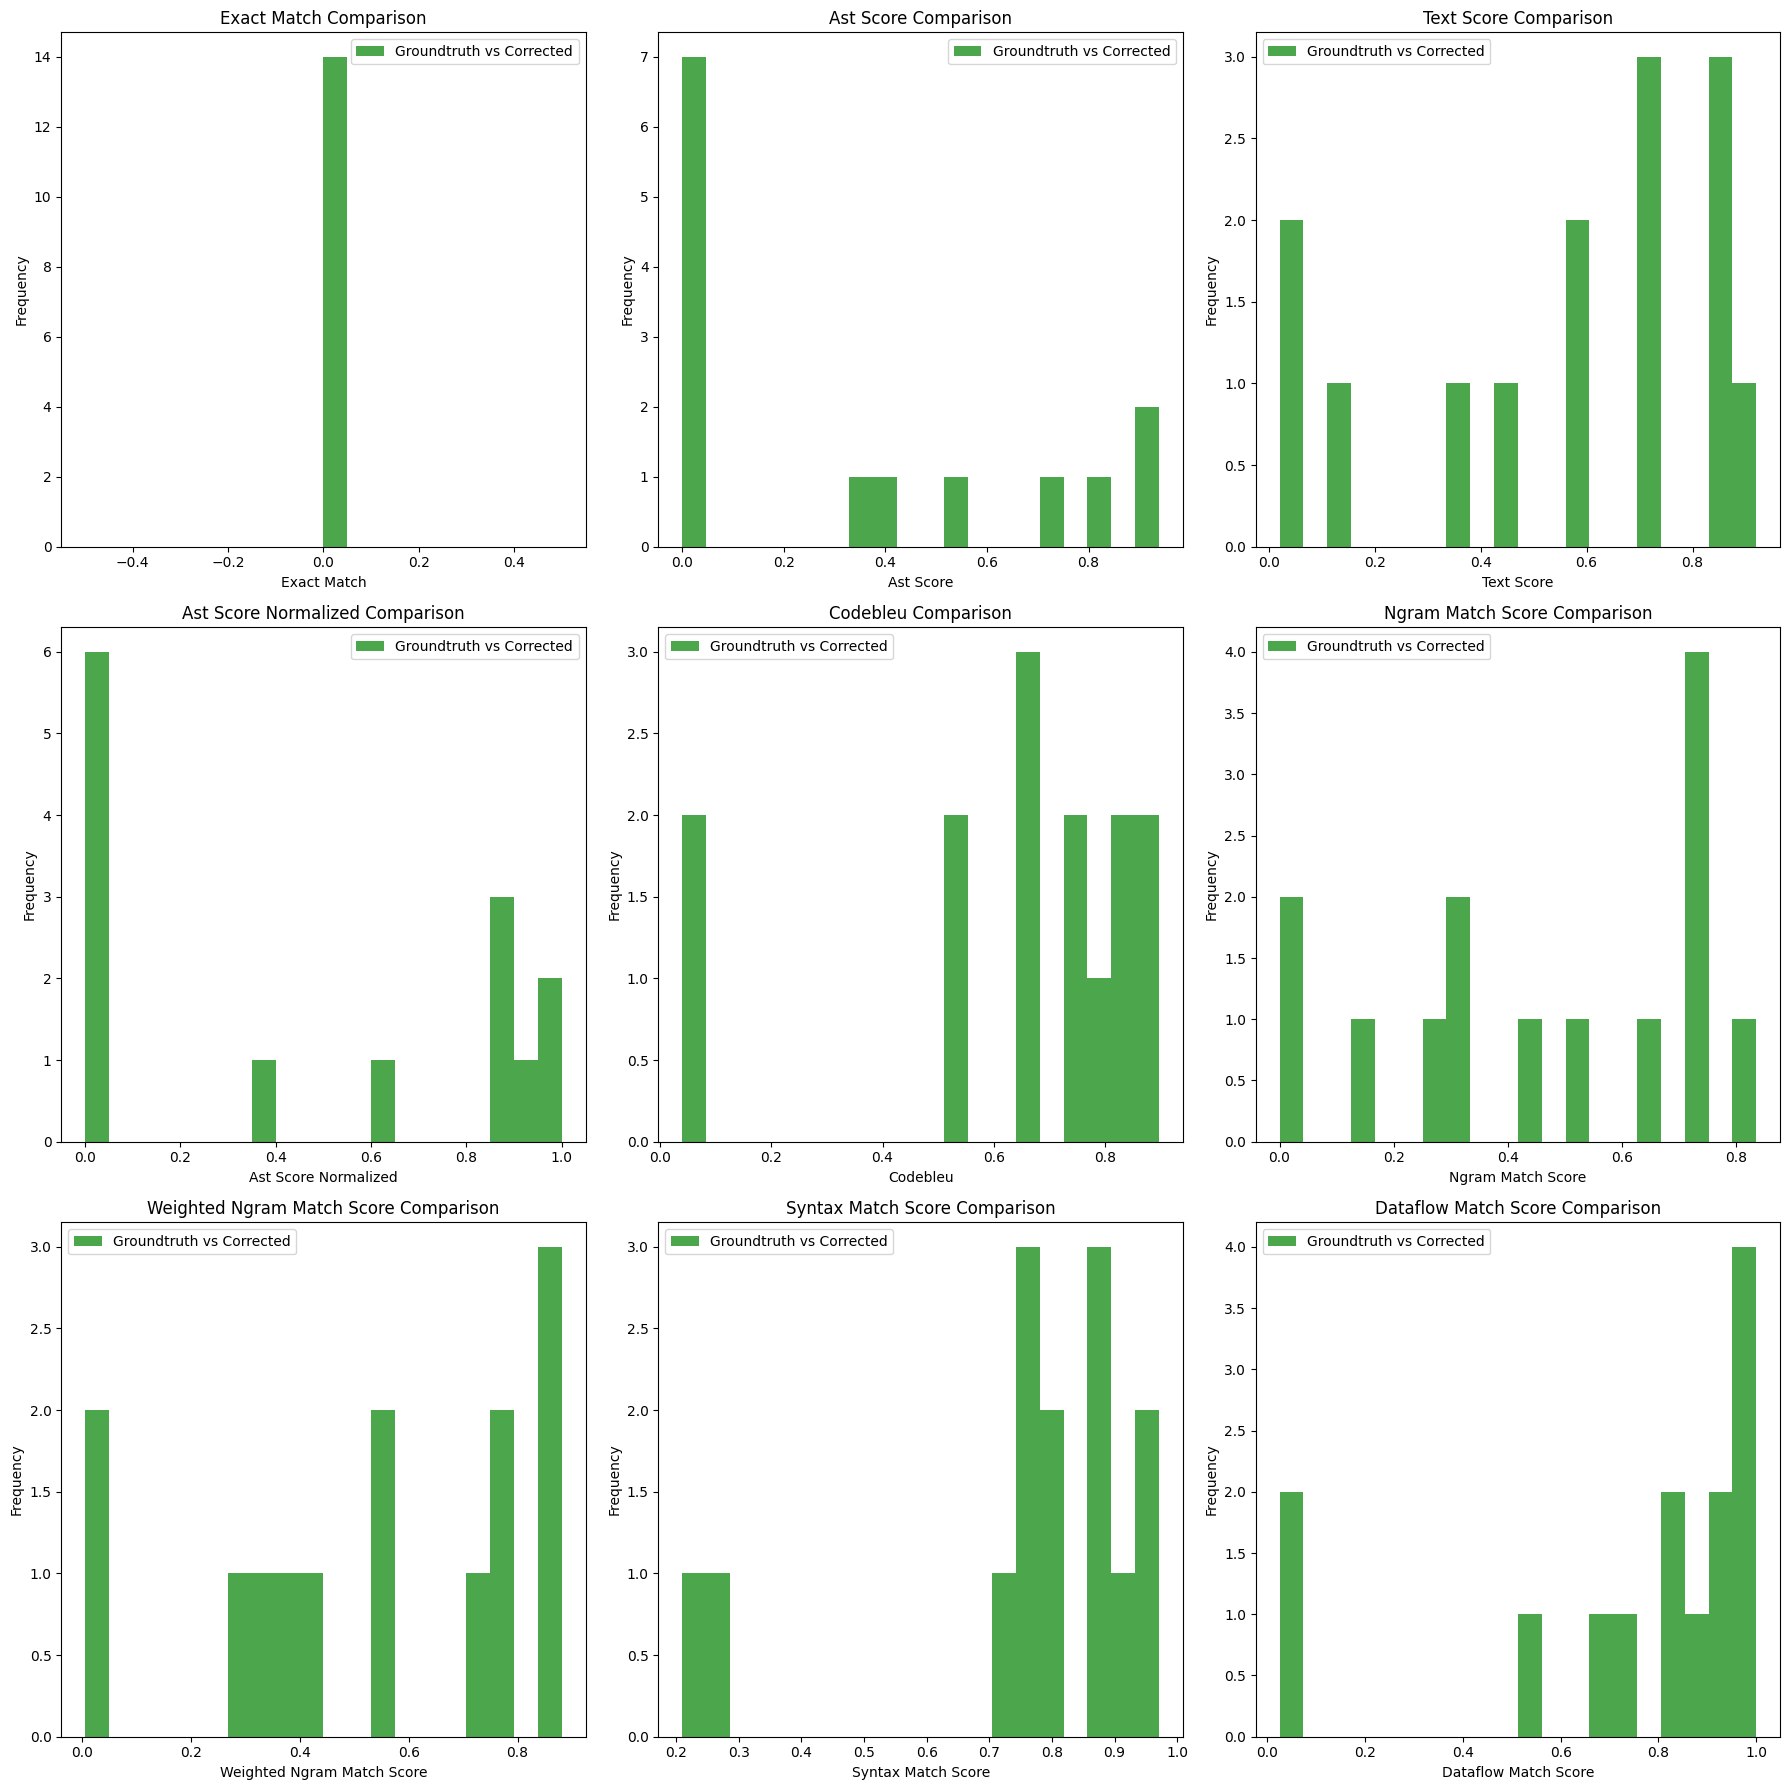

=== GROUNDTRUTH VS CORRECTED METRICS STATISTICS ===
Exact Match - Groundtruth vs Corrected: mean=0.000, std=0.000
Ast Score - Groundtruth vs Corrected: mean=0.342, std=0.374
Text Score - Groundtruth vs Corrected: mean=0.563, std=0.301
Ast Score Normalized - Groundtruth vs Corrected: mean=0.468, std=0.428
Codebleu - Groundtruth vs Corrected: mean=0.630, std=0.264
Ngram Match Score - Groundtruth vs Corrected: mean=0.465, std=0.280
Weighted Ngram Match Score - Groundtruth vs Corrected: mean=0.531, std=0.285
Syntax Match Score - Groundtruth vs Corrected: mean=0.751, std=0.223
Dataflow Match Score - Groundtruth vs Corrected: mean=0.740, std=0.316


In [20]:
compare_groundtruth_vs_corrected_histograms(sample_data[sample_data['traceback_type'] == 'ValueError']
                                            ['after_merge'], sample_data[sample_data['traceback_type'] == 'ValueError']['response_gpt-4o-mini'])

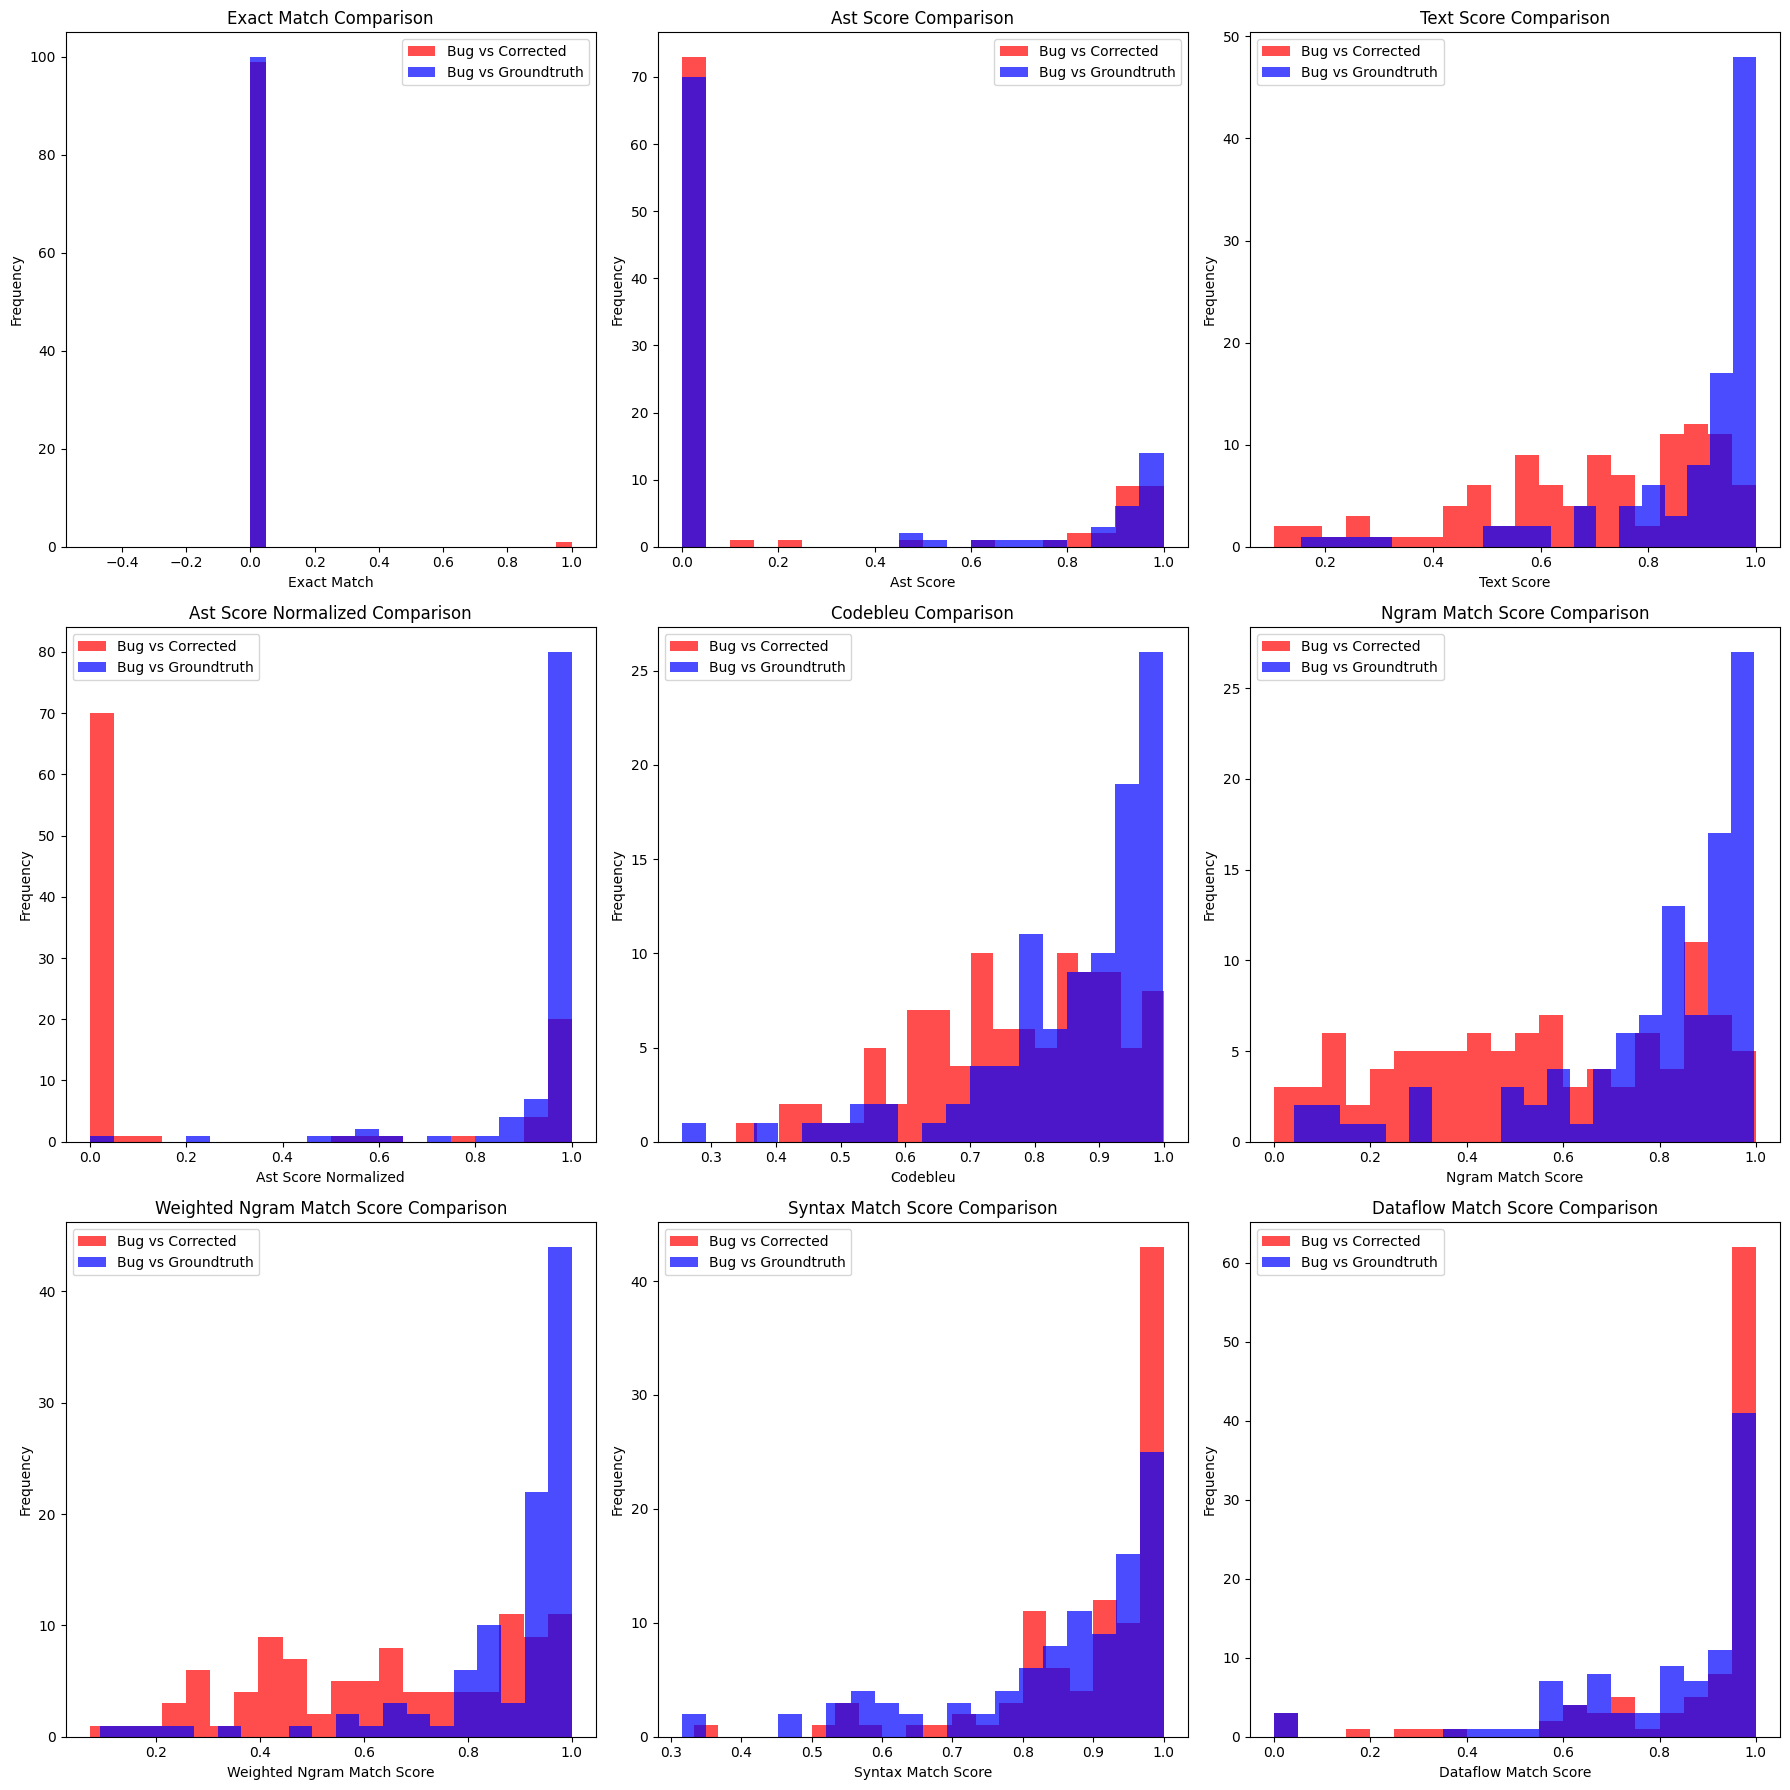

=== ALL METRICS STATISTICS ===
Exact Match - Bug vs Corrected: mean=0.010, std=0.099
Exact Match - Bug vs Groundtruth: mean=0.000, std=0.000
Ast Score - Bug vs Corrected: mean=0.229, std=0.393
Ast Score - Bug vs Groundtruth: mean=0.262, std=0.410
Text Score - Bug vs Corrected: mean=0.693, std=0.224
Text Score - Bug vs Groundtruth: mean=0.879, std=0.176
Ast Score Normalized - Bug vs Corrected: mean=0.262, std=0.421
Ast Score Normalized - Bug vs Groundtruth: mean=0.945, std=0.157
Codebleu - Bug vs Corrected: mean=0.765, std=0.151
Codebleu - Bug vs Groundtruth: mean=0.855, std=0.145
Ngram Match Score - Bug vs Corrected: mean=0.547, std=0.287
Ngram Match Score - Bug vs Groundtruth: mean=0.789, std=0.232
Weighted Ngram Match Score - Bug vs Corrected: mean=0.649, std=0.251
Weighted Ngram Match Score - Bug vs Groundtruth: mean=0.870, std=0.188
Syntax Match Score - Bug vs Corrected: mean=0.898, std=0.131
Syntax Match Score - Bug vs Groundtruth: mean=0.847, std=0.160
Dataflow Match Score - Bug 

In [21]:
# Call the function with the lists
compare_metrics_versus_bug_histograms(
    sample_data['before_merge'], sample_data['after_merge'], sample_data['response_qwen-2.5-coder-32b-instruct'])

In [22]:
from utils.simple_metrics import codebleu
codebleu_scores = codebleu(
    sample_data['before_merge'].iloc[0], sample_data['after_merge'].iloc[0])
print(codebleu_scores)

{'codebleu': 0.6902929241254429, 'ngram_match_score': 0.8105822848596743, 'weighted_ngram_match_score': 0.8163683928454585, 'syntax_match_score': 0.6046511627906976, 'dataflow_match_score': 0.5555555555555556}


In [23]:
codebleu_scores = codebleu(sample_data['before_merge_without_docstrings'].iloc[0],
                           sample_data['after_merge_without_docstrings'].iloc[0])
print(codebleu_scores)

{'codebleu': 0.5727627444937661, 'ngram_match_score': 0.5714392512385289, 'weighted_ngram_match_score': 0.5823287021715529, 'syntax_match_score': 0.6046511627906976, 'dataflow_match_score': 0.5555555555555556}


In [24]:
print(sample_data['response_gpt-4o-mini'].iloc[0])

async def stop_notify(self, _uuid: str) -> None:
    char_props = self.characteristics.get(_uuid)
    if char_props is None:
        return
    await self._bus.callRemote(
        char_props.get("Path"),
        "StopNotify",
        interface=defs.GATT_CHARACTERISTIC_INTERFACE,
        destination=defs.BLUEZ_SERVICE,
        signature="",
        body=[],
        returnSignature="",
    ).asFuture(self.loop)
    self._notification_callbacks.pop(char_props.get("Path"), None)
